In [1]:
# import the libraries
import iimp6010
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose as mr
import pandas
import math

## Visualize the city

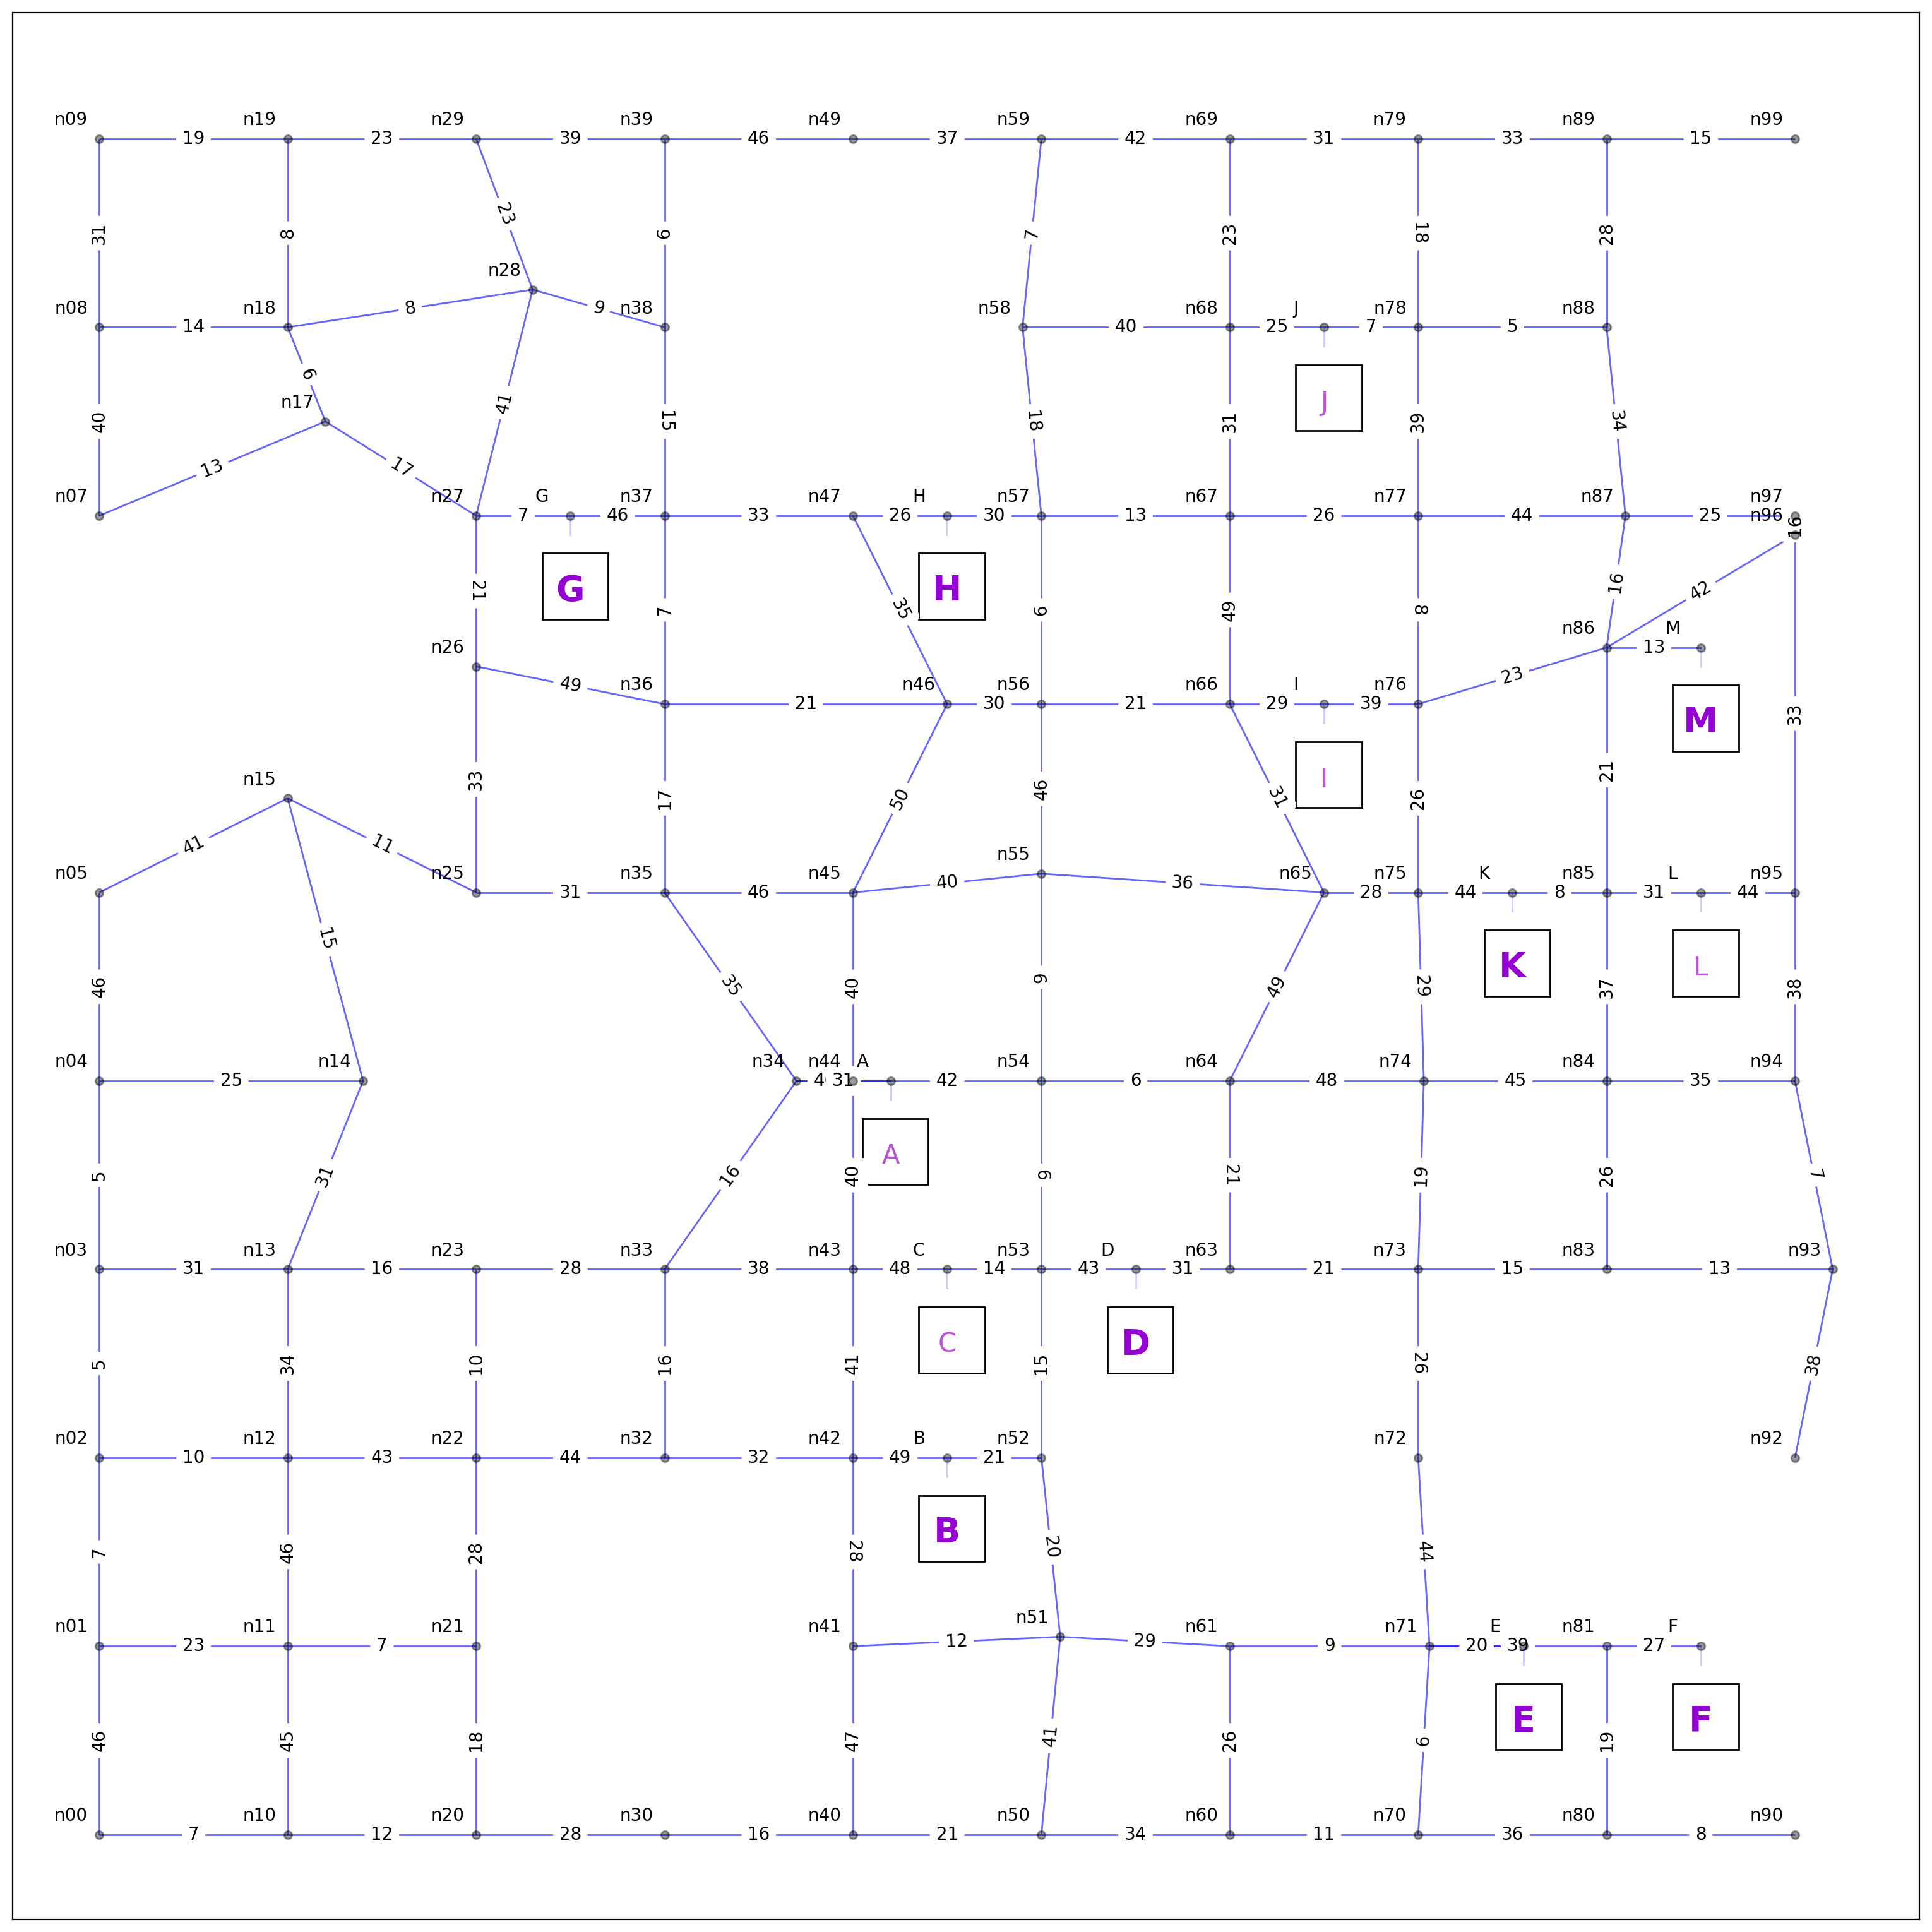

In [2]:
city = iimp6010.generate_city(0.1, 0.2)
iimp6010.save_city_to_file(city)
city = iimp6010.load_city()
iimp6010.visualize_city(city)
G = city.graph

## Solve TSP problems

In [3]:
def tsp_res(node_list):
    # Calculate the number of nodes in the list.
    num_nodes = len(node_list)
    # Create dictionary to store the nodes with its ids.
    dic = dict(zip(node_list,range(len(node_list))))
    dic_re = dict(zip(range(len(node_list)),node_list))
    
    # Create list of distances between pairs of cities
    dist_list = []
    for nodes in list(combinations(node_list,2)):
        node = list(nodes)
        node.append(nx.shortest_path_length(city.graph, source=nodes[0], target=nodes[1],weight='weight'))
        dist_list.append((dic[nodes[0]],dic[nodes[1]],nx.shortest_path_length(city.graph, source=nodes[0], target=nodes[1],weight='weight')))
    
    # Initialize fitness function object using dist_list
    fitness_dists = mr.TravellingSales(distances = dist_list)
    # Define optimization problem object
    problem_fit = mr.TSPOpt(length = num_nodes, fitness_fn = fitness_dists, maximize=False)

    best_state, best_fitness = mr.genetic_alg(problem_fit, mutation_prob = 0.2,
                                            max_attempts = 100, random_state = 2)
    path = []
    for i in best_state:
        path.append(dic_re[i])
    return best_fitness, path
    

def best_tours(buildings):
    all_nodes = buildings
    best_fitness, path = tsp_res(buildings)
    print('The best fitness is %.2f'%(best_fitness) )    
    print('Shortest tours:',path)
    return path

def visualization_of_tours(path):
    tsp_path=[]
    for i in range(0,len(path)-1):
        if i == 0:
            tsp_path = tsp_path + nx.shortest_path(city.graph, source=path[i], target=path[i+1],weight='weight')
        if i > 0:
            tsp_path = tsp_path + nx.shortest_path(city.graph, source=path[i], target=path[i+1],weight='weight')[1:] 
    tsp_path = tsp_path +  nx.shortest_path(city.graph, source=path[-1], target=path[0],weight='weight')[1:]
    iimp6010.visualize_path_in_city(city,tsp_path)

## Add weather condition

In [4]:
# We collect bikes from buildings where the number of bikes is bigger than 30.
Buildings = [b['id'] for b in city.building_nodes if b['num_bikes']>=30]
print('Buildings we choose:',Buildings)

# Select a random area as the raining area which is centered on a building.
rain_center = iimp6010.random_select(Buildings,1)[0]
print('We choose the building %s as the raining center'%rain_center)

# Build a ego graph with the building we choose as the center.
# Use Mahattan distance to seperate a raining area. 
def rain(G,rain_center,r,degree,display=True,delta=15):
    '''
    r: radius of the raining area.
    delta: weights increase for edges in the raining area.
    degree: degree of the rainfall.
    '''
    ego=nx.ego_graph(G, rain_center,radius=r, center=True, distance='distance')
    
    if degree=='heavy':
        color='dodgerblue'
        delta+=25
    elif degree=='middle':
        color='deepskyblue'
        delta+=10
    else:
        color='lightblue'
        
    # Visualize the raining area.
    nx.draw_networkx(ego,pos=city.node_positions,edge_color=color,
                           width=8,alpha=0.7,node_size=30,node_color='gray',font_size=10)
    lables = nx.get_edge_attributes(ego,'weight')
    print('Previous ego-graph:')
    nx.draw_networkx_edge_labels(ego,pos=city.node_positions,edge_labels=lables)
    plt.show()

    ego_edges = ego.edges()
    for edge in ego_edges:
        G.edges[edge]['weight']+=delta
        ego.edges[edge]['weight']+=delta
    print('Ego-graph with weights updated:')
    nx.draw_networkx(ego,pos=city.node_positions,edge_color=color,
                           width=8,alpha=0.7,node_size=30,node_color='gray',font_size=10)
    lables = nx.get_edge_attributes(ego,'weight')
    nx.draw_networkx_edge_labels(ego,pos=city.node_positions,edge_labels=lables)
    if display:
        iimp6010.visualize_rain_path(city,ego_edges,degree)
    
    return G,ego_edges

Buildings we choose: ['B', 'D', 'E', 'F', 'G', 'H', 'K', 'M']
We choose the building H as the raining center


Previous ego-graph:


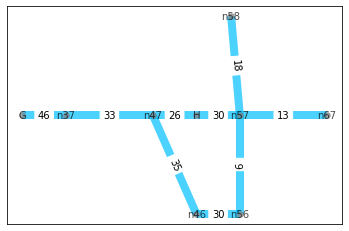

Ego-graph with weights updated:


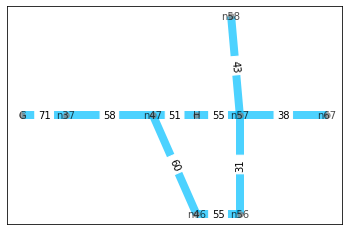

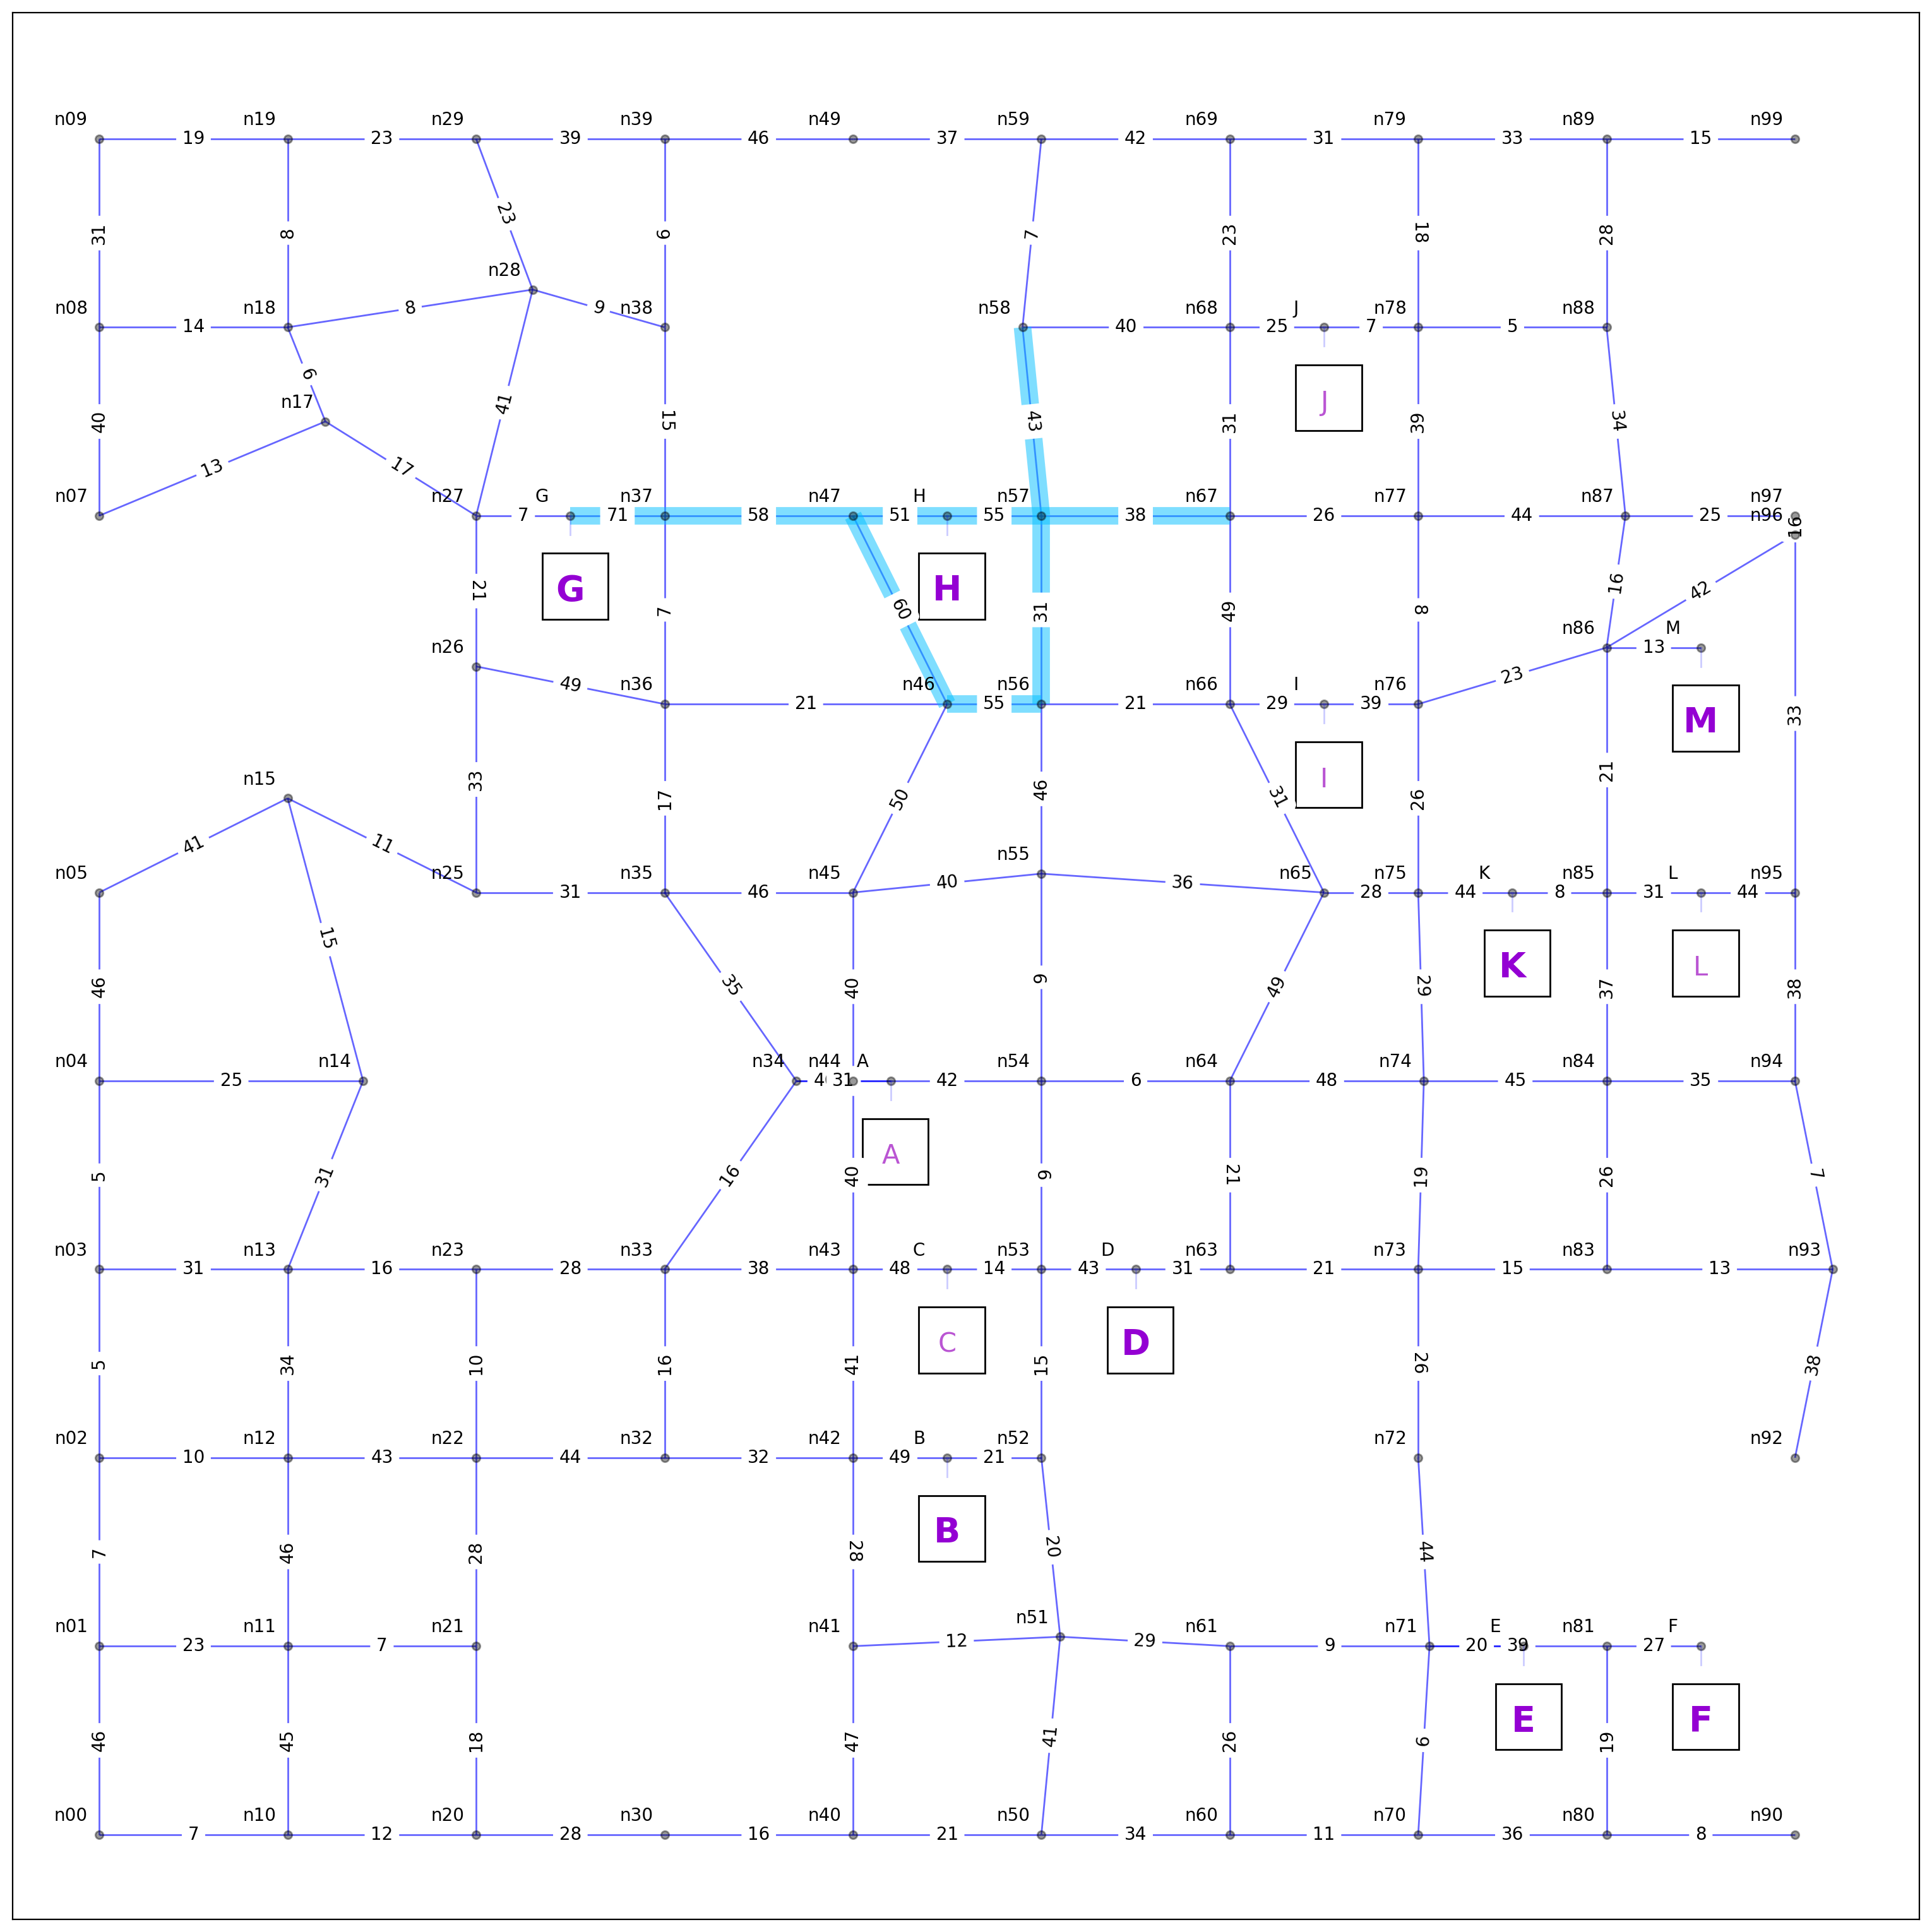

(<networkx.classes.graph.Graph at 0x110482040>,
 EdgeView([('n56', 'n46'), ('n56', 'n57'), ('n57', 'n67'), ('n57', 'n58'), ('n57', 'H'), ('n37', 'n47'), ('n37', 'G'), ('n47', 'n46'), ('n47', 'H')]))

In [5]:
rain(G,rain_center,200,'middle')

## Add traffic condition

In [6]:
# Select a random area as the traffic busy area which is centered on a building.
Buildings = [b['id'] for b in city.building_nodes]
traffic_center = iimp6010.random_select(Buildings,1)[0]

# Build a ego graph with the building we choose as the center.
# Use number of paths to seperate a traffic busy area. 
def traffic(G,traffic_center,r,degree,display=True,delta=20):
    '''
    r: radius of the traffic busy area.
    delta: weights increase for edges in the busy area.
    degree: degree of the traffic.
    '''
    ego=nx.ego_graph(G, traffic_center,radius=r, center=True)
    
    if degree=='heavy':
        color='red'
        delta+=30
    else:
        color='tomato'
    
    # Visualize the raining area.
    nx.draw_networkx(ego,pos=city.node_positions,edge_color=color,
                           width=8,alpha=0.7,node_size=30,node_color='gray',font_size=10)
    lables = nx.get_edge_attributes(ego,'weight')
    print('Previous ego-graph:')
    nx.draw_networkx_edge_labels(ego,pos=city.node_positions,edge_labels=lables)
    plt.show()

    ego_edges = ego.edges()
    for edge in ego_edges:
        G.edges[edge]['weight']+=delta
        ego.edges[edge]['weight']+=delta
    print('Ego-graph with weights updated:')
    nx.draw_networkx(ego,pos=city.node_positions,edge_color=color,
                           width=8,alpha=0.7,node_size=30,node_color='gray',font_size=10)
    lables = nx.get_edge_attributes(ego,'weight')
    nx.draw_networkx_edge_labels(ego,pos=city.node_positions,edge_labels=lables)
        
    if display:
        iimp6010.visualize_busy_path(city,ego_edges,degree)
    return G,ego_edges

Previous ego-graph:


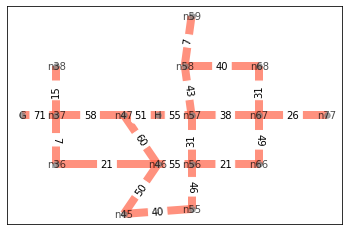

Ego-graph with weights updated:


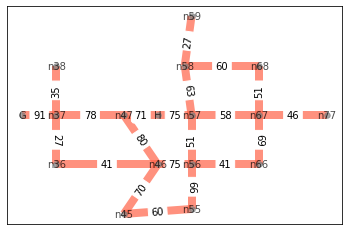

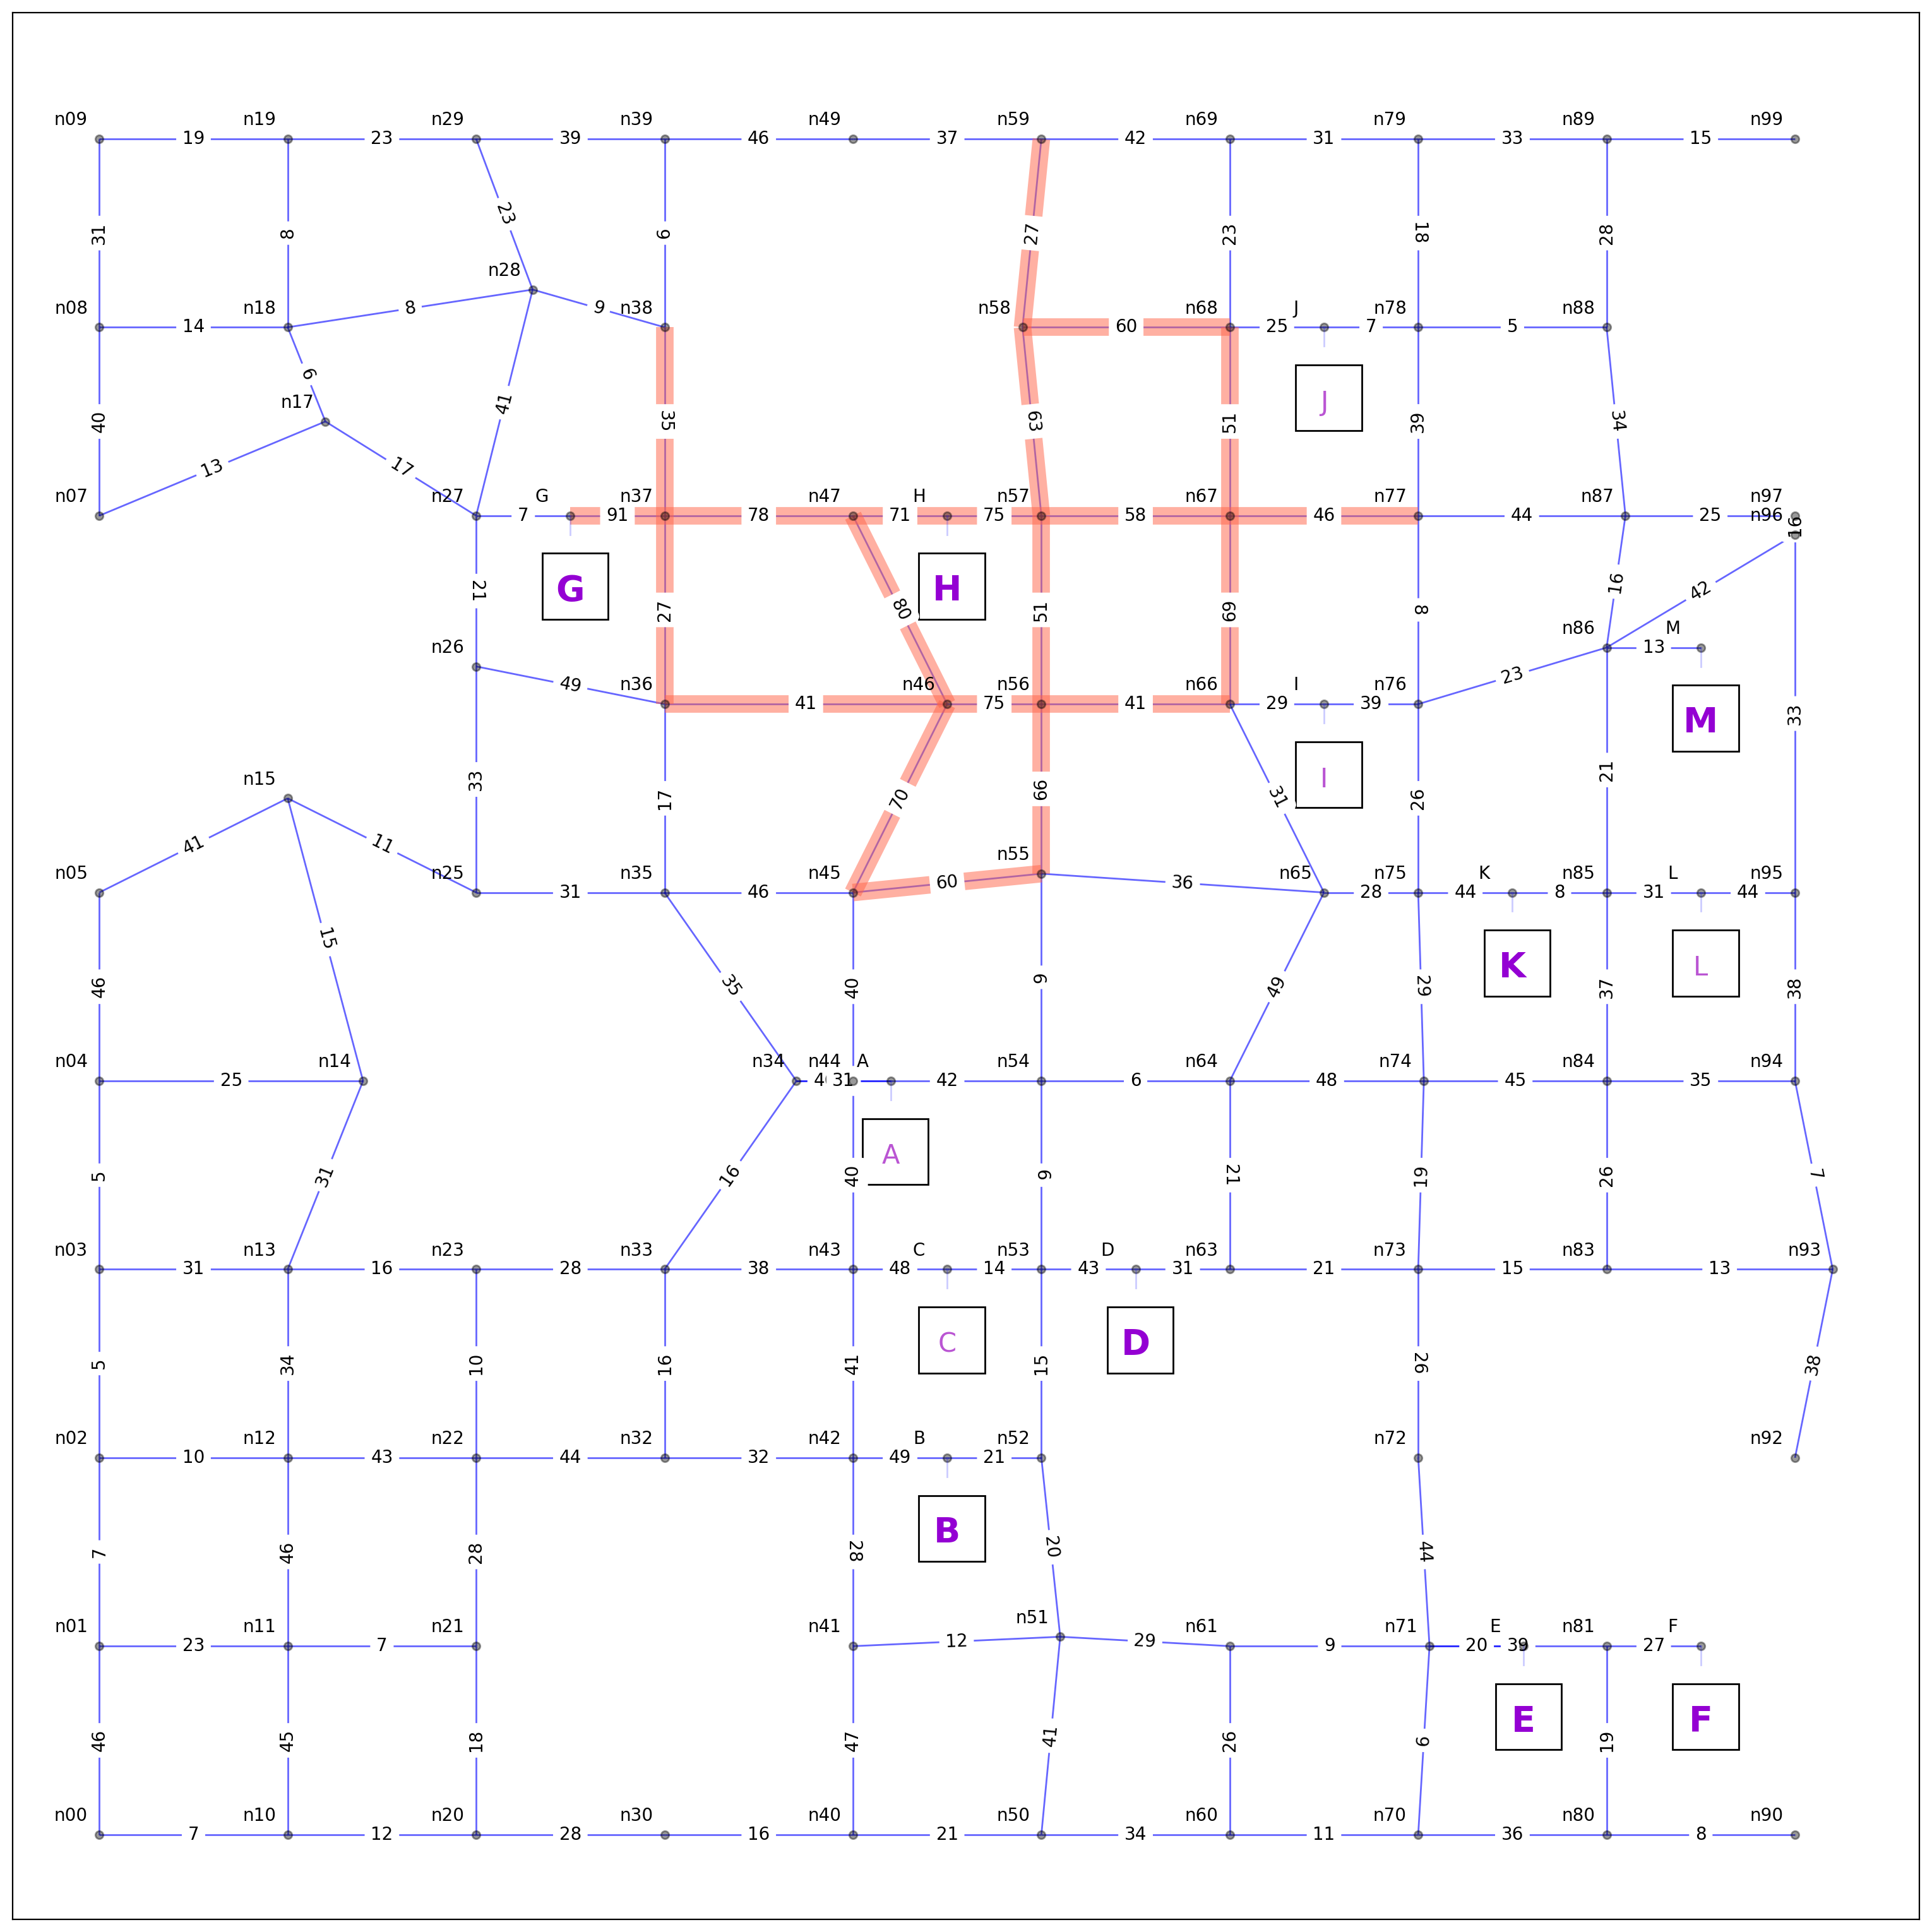

(<networkx.classes.graph.Graph at 0x110482040>,
 EdgeView([('n56', 'n46'), ('n56', 'n55'), ('n56', 'n57'), ('n56', 'n66'), ('n55', 'n45'), ('n57', 'n67'), ('n57', 'n58'), ('n57', 'H'), ('n37', 'n36'), ('n37', 'n38'), ('n37', 'n47'), ('n37', 'G'), ('n47', 'n46'), ('n47', 'H'), ('n59', 'n58'), ('n67', 'n66'), ('n67', 'n68'), ('n67', 'n77'), ('n46', 'n36'), ('n46', 'n45'), ('n68', 'n58')]))

In [7]:
traffic(G,rain_center,3,'fine')

## TSP results under different condition

In [8]:
def TSP_tours(condition,graph,r,degree):
    '''
    condition: Add weather or traffic condition to TSP problems
    r: radius of the area be affected
    degree: degree of conditions
    '''
    Buildings = [b['id'] for b in city.building_nodes if b['num_bikes']>=30]
    print('Buildings we choose:',Buildings)

    center = iimp6010.random_select(Buildings,1)[0]
    print('We choose the building %s as the center'%center)

    if condition=='weather':
        r=r*100
        # Update the graph with new weights for a certain area.
        G_new,_ = rain(graph,center,r,degree)
    elif condition=='traffic':
        G_new,_ = traffic(graph,center,r,degree)
    else:
        G_new = G # Just copy  
    path = best_tours(Buildings)
    visualization_of_tours(path)
    return

## Test and Compare

Buildings we choose: ['B', 'D', 'E', 'F', 'G', 'H', 'K', 'M']
We choose the building E as the center
The best fitness is 1233.00
Shortest tours: ['D', 'K', 'M', 'H', 'G', 'F', 'E', 'B']


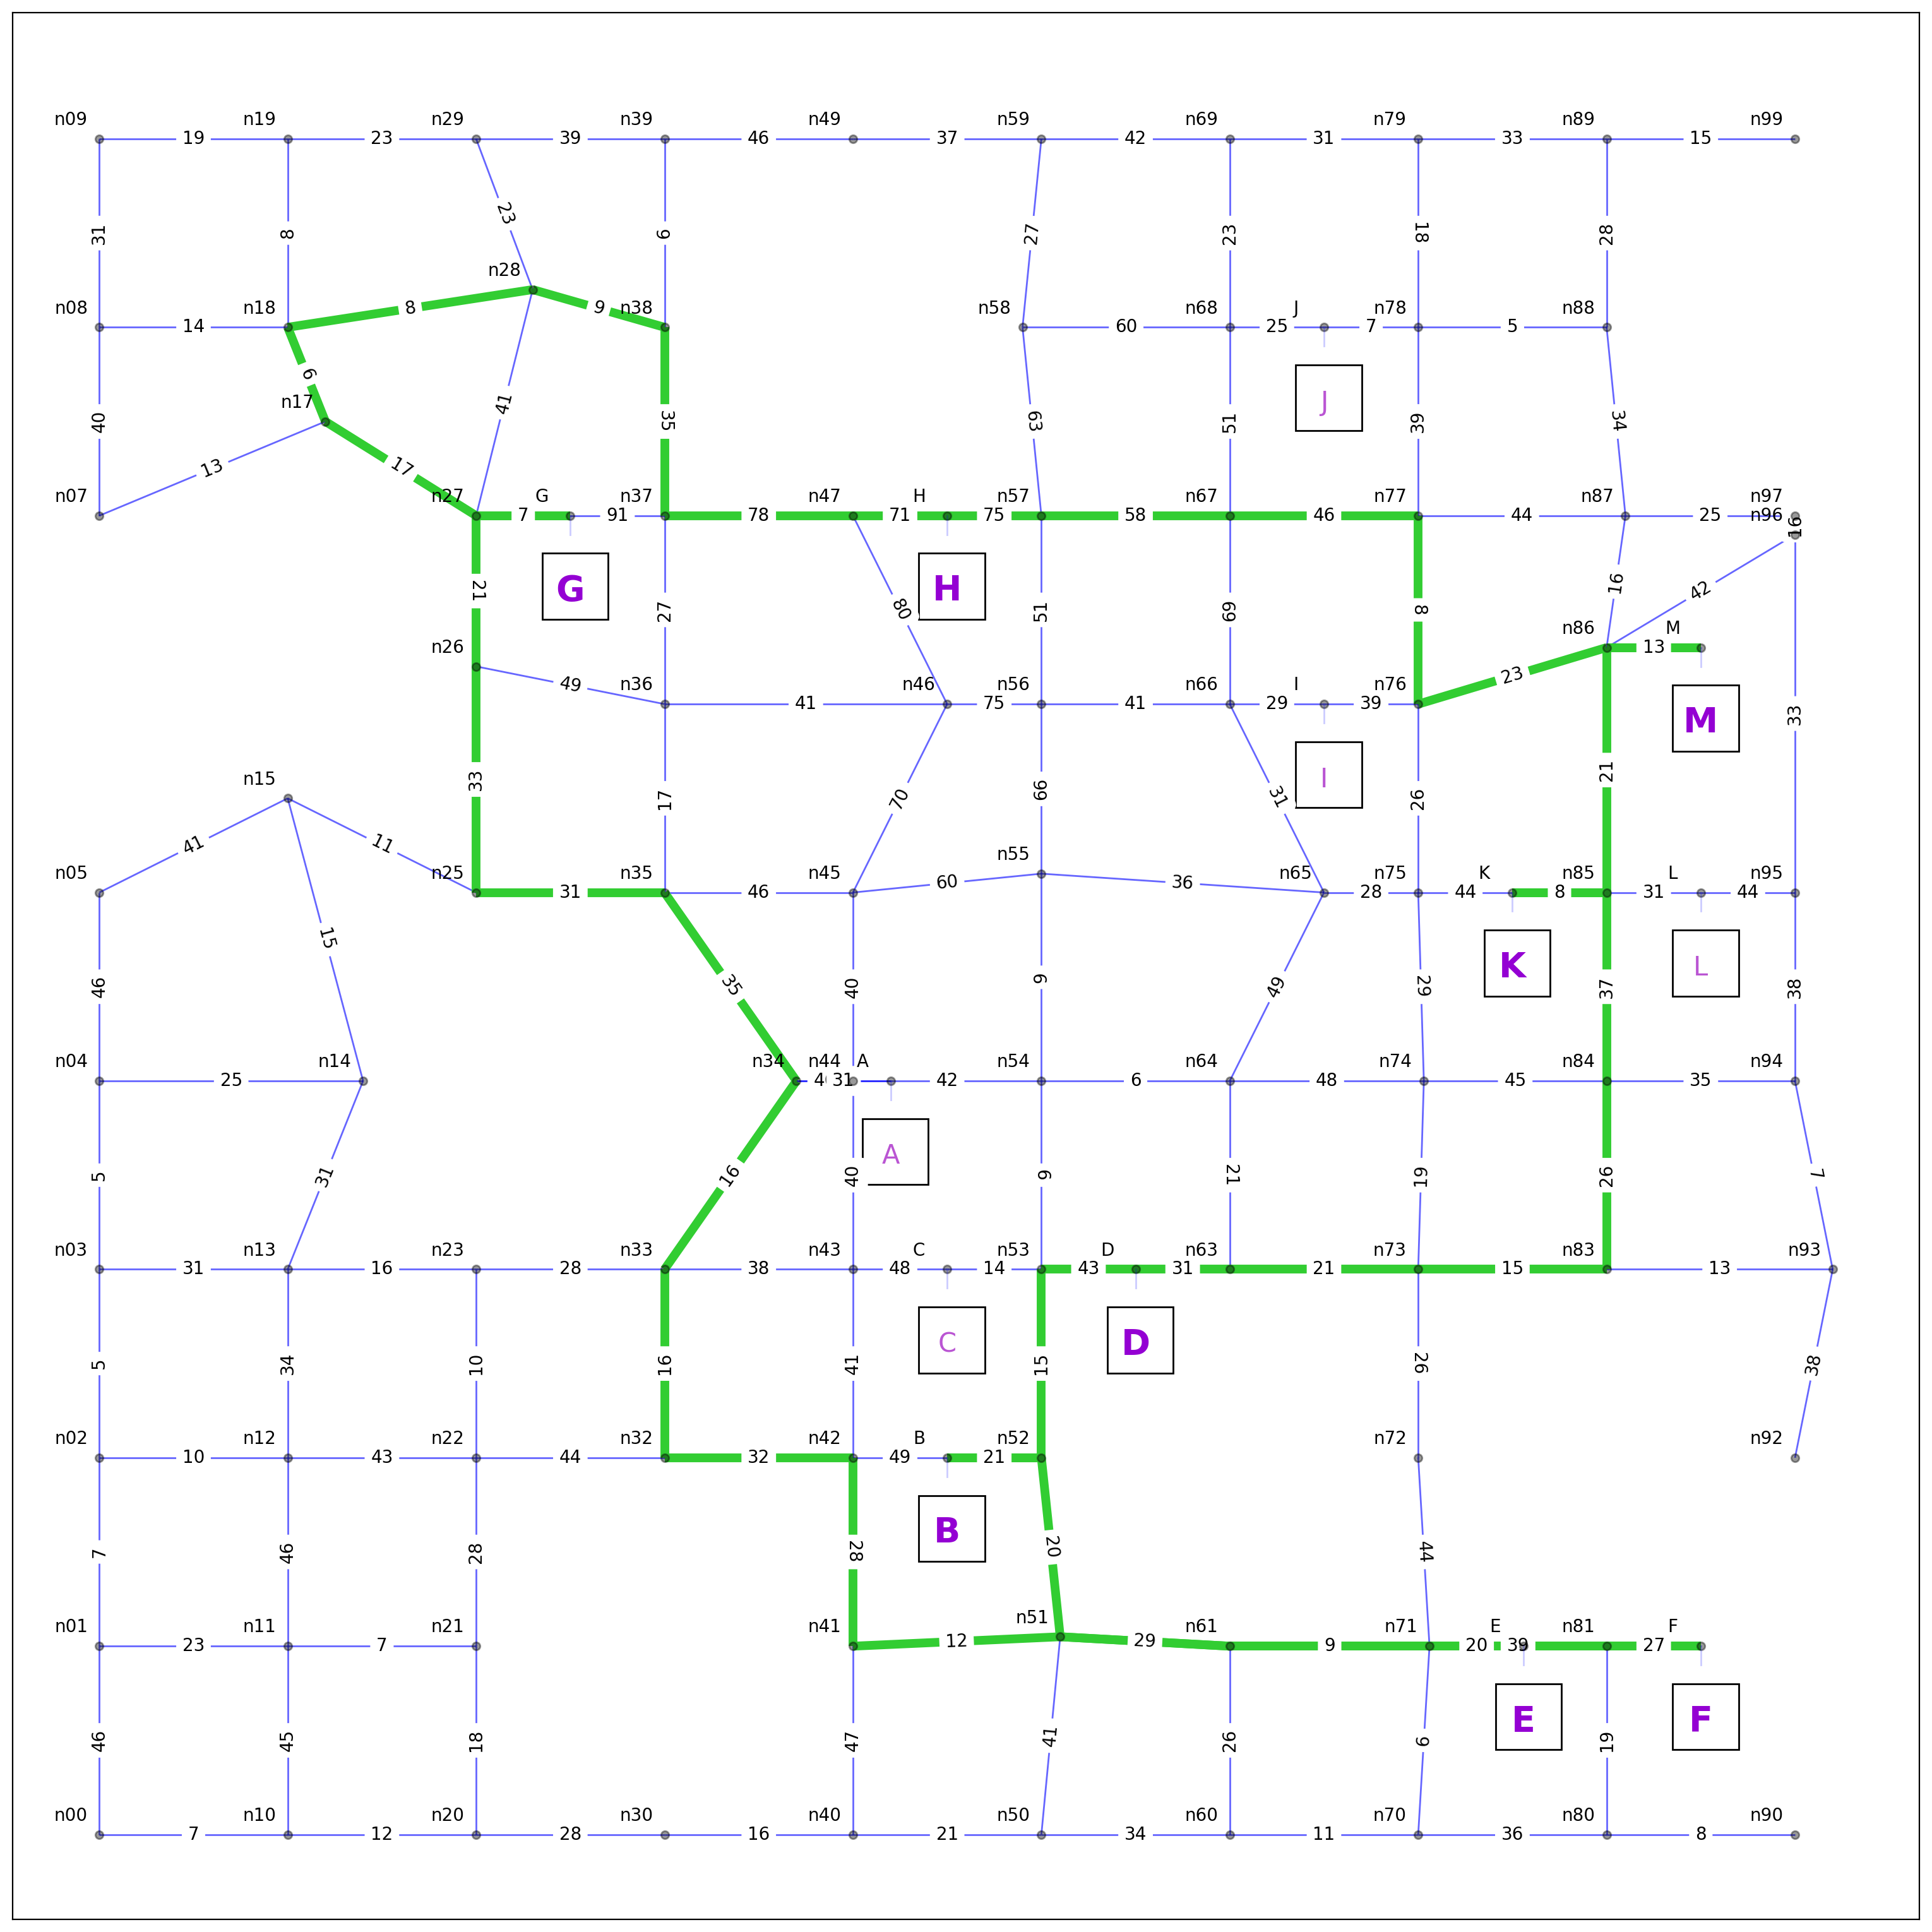

In [9]:
TSP_tours(None,G,None,None)

Buildings we choose: ['B', 'D', 'E', 'F', 'G', 'H', 'K', 'M']
We choose the building E as the center
Previous ego-graph:


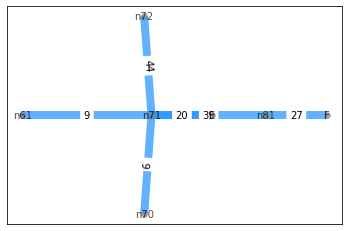

Ego-graph with weights updated:


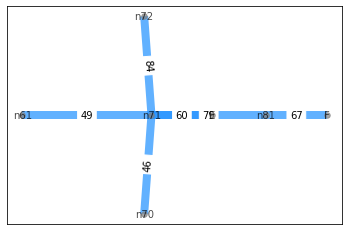

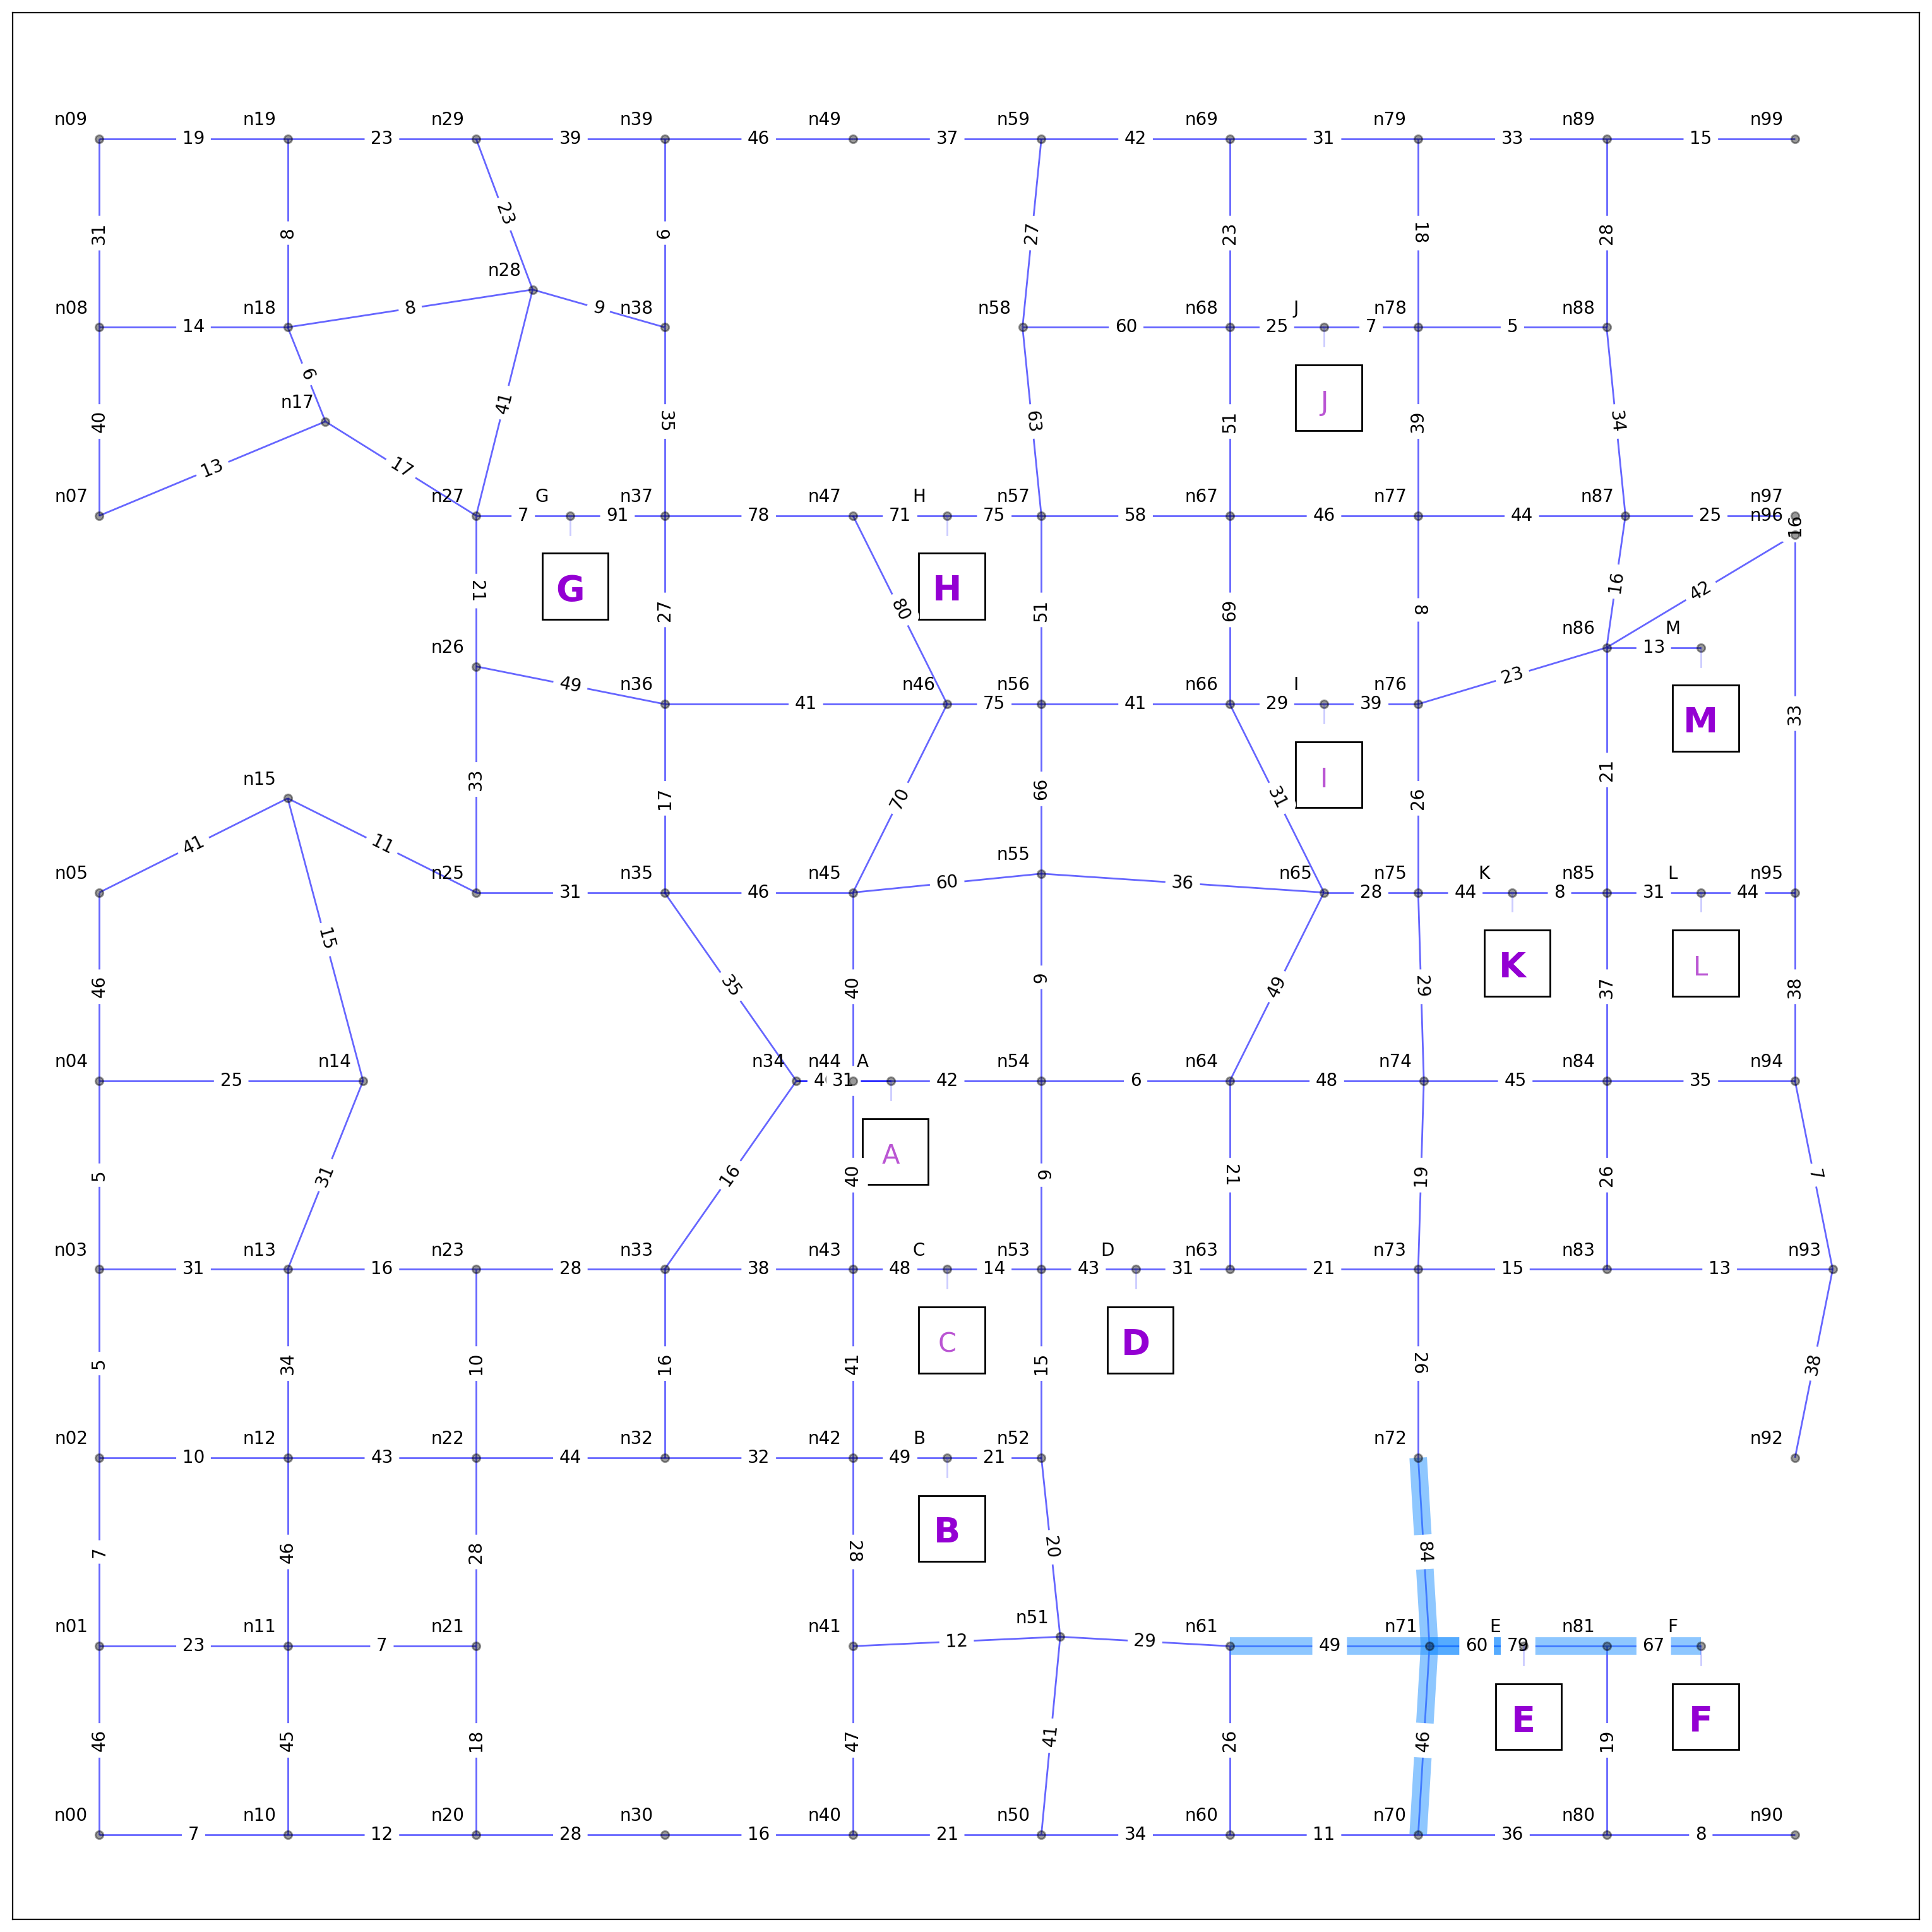

The best fitness is 1507.00
Shortest tours: ['E', 'B', 'D', 'K', 'M', 'H', 'G', 'F']


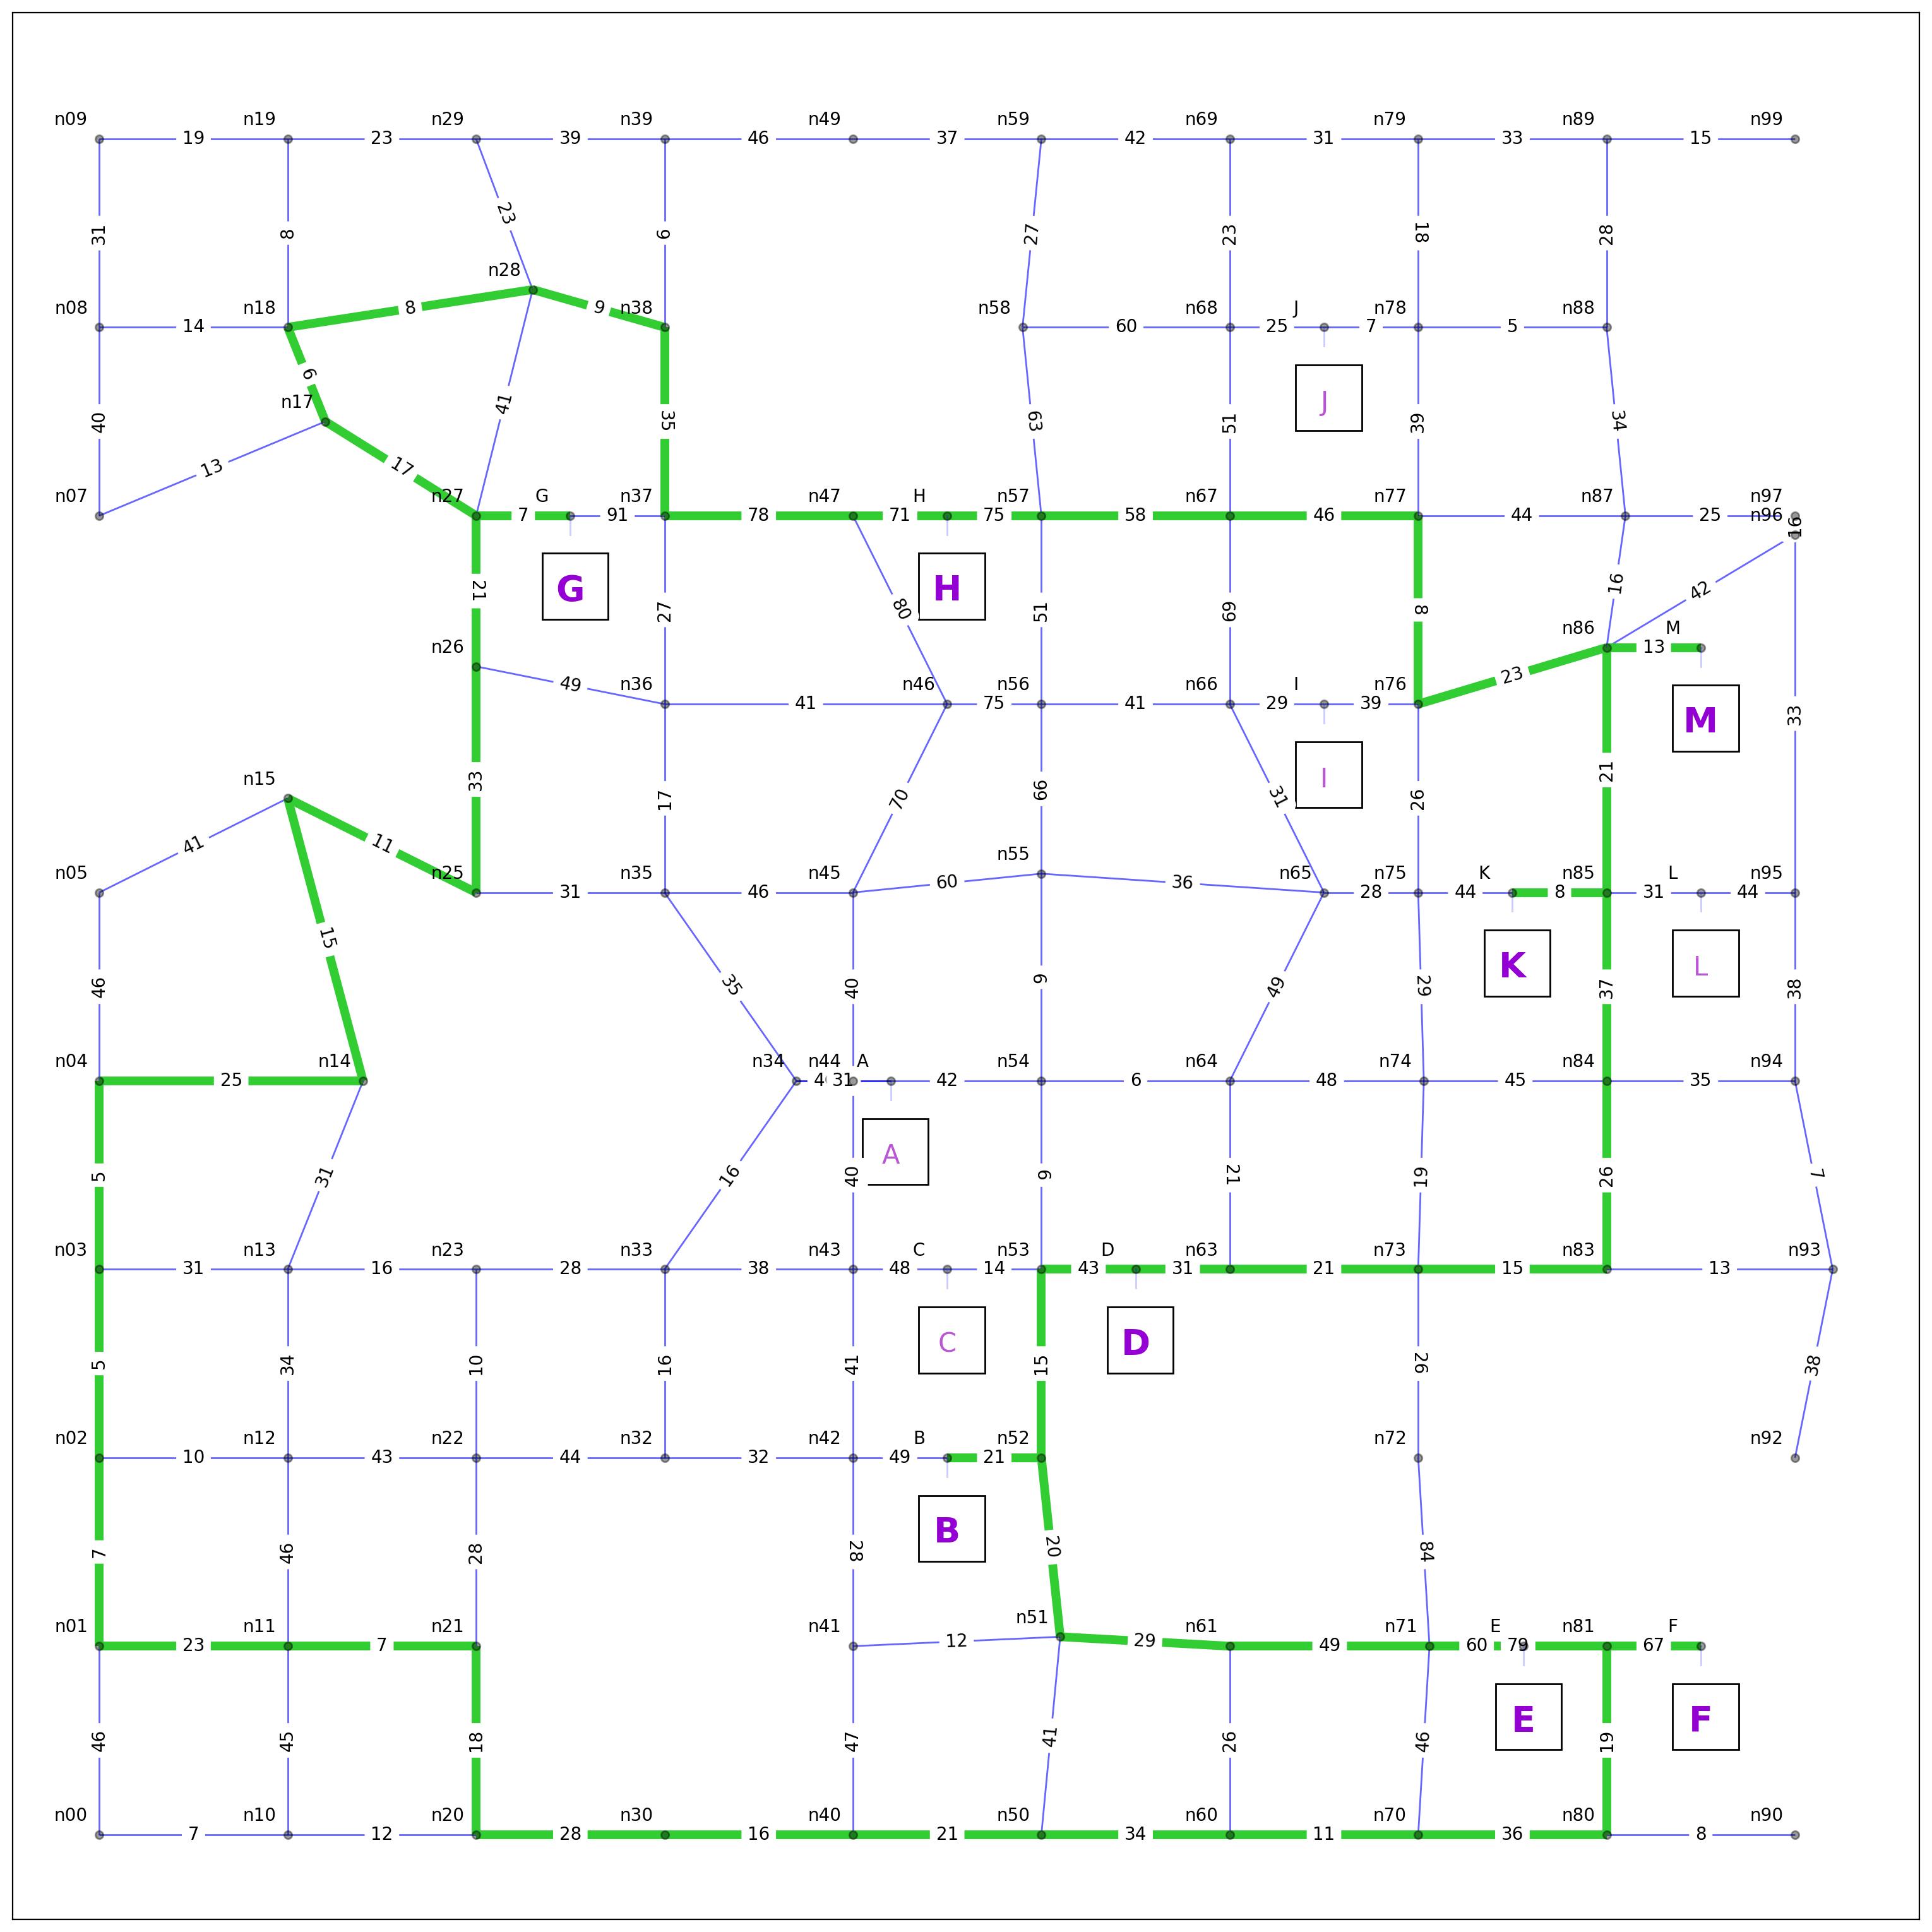

In [10]:
TSP_tours('weather',G,2,'heavy')

Buildings we choose: ['B', 'D', 'E', 'F', 'G', 'H', 'K', 'M']
We choose the building K as the center
Previous ego-graph:


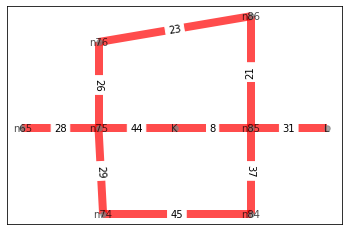

Ego-graph with weights updated:


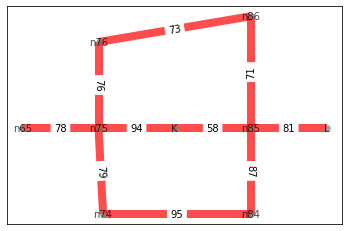

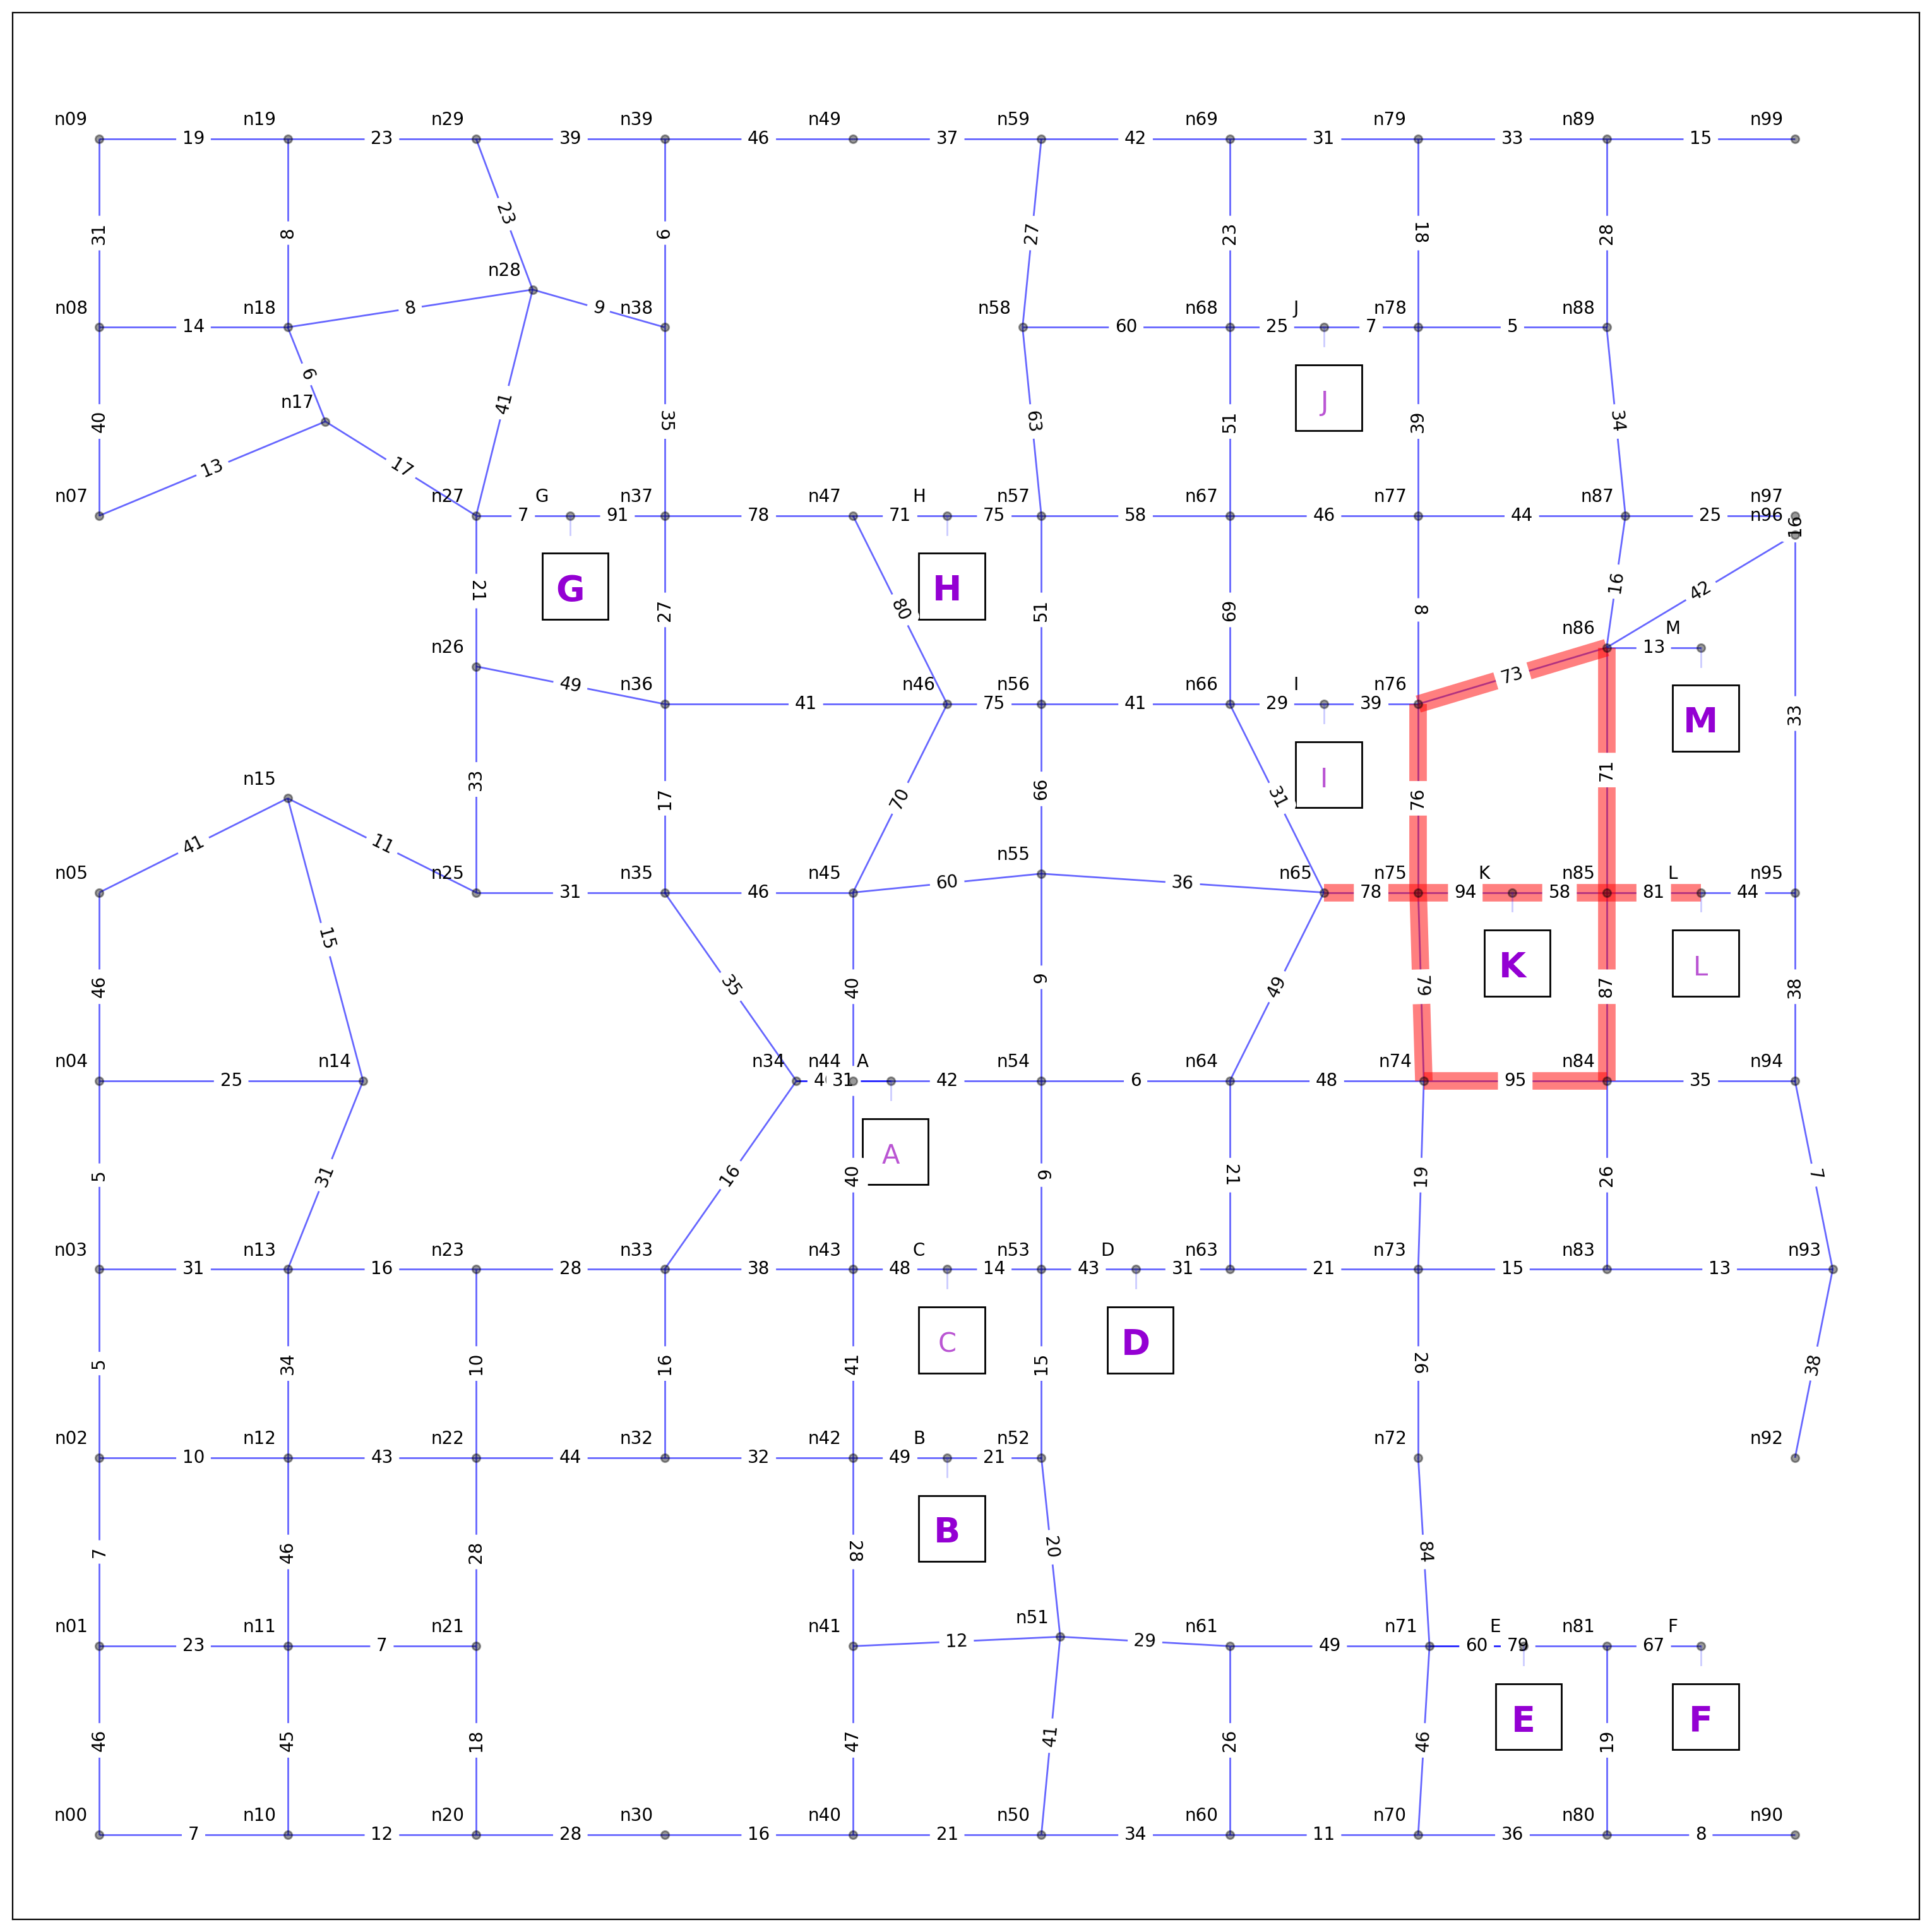

The best fitness is 1736.00
Shortest tours: ['D', 'K', 'M', 'H', 'G', 'F', 'E', 'B']


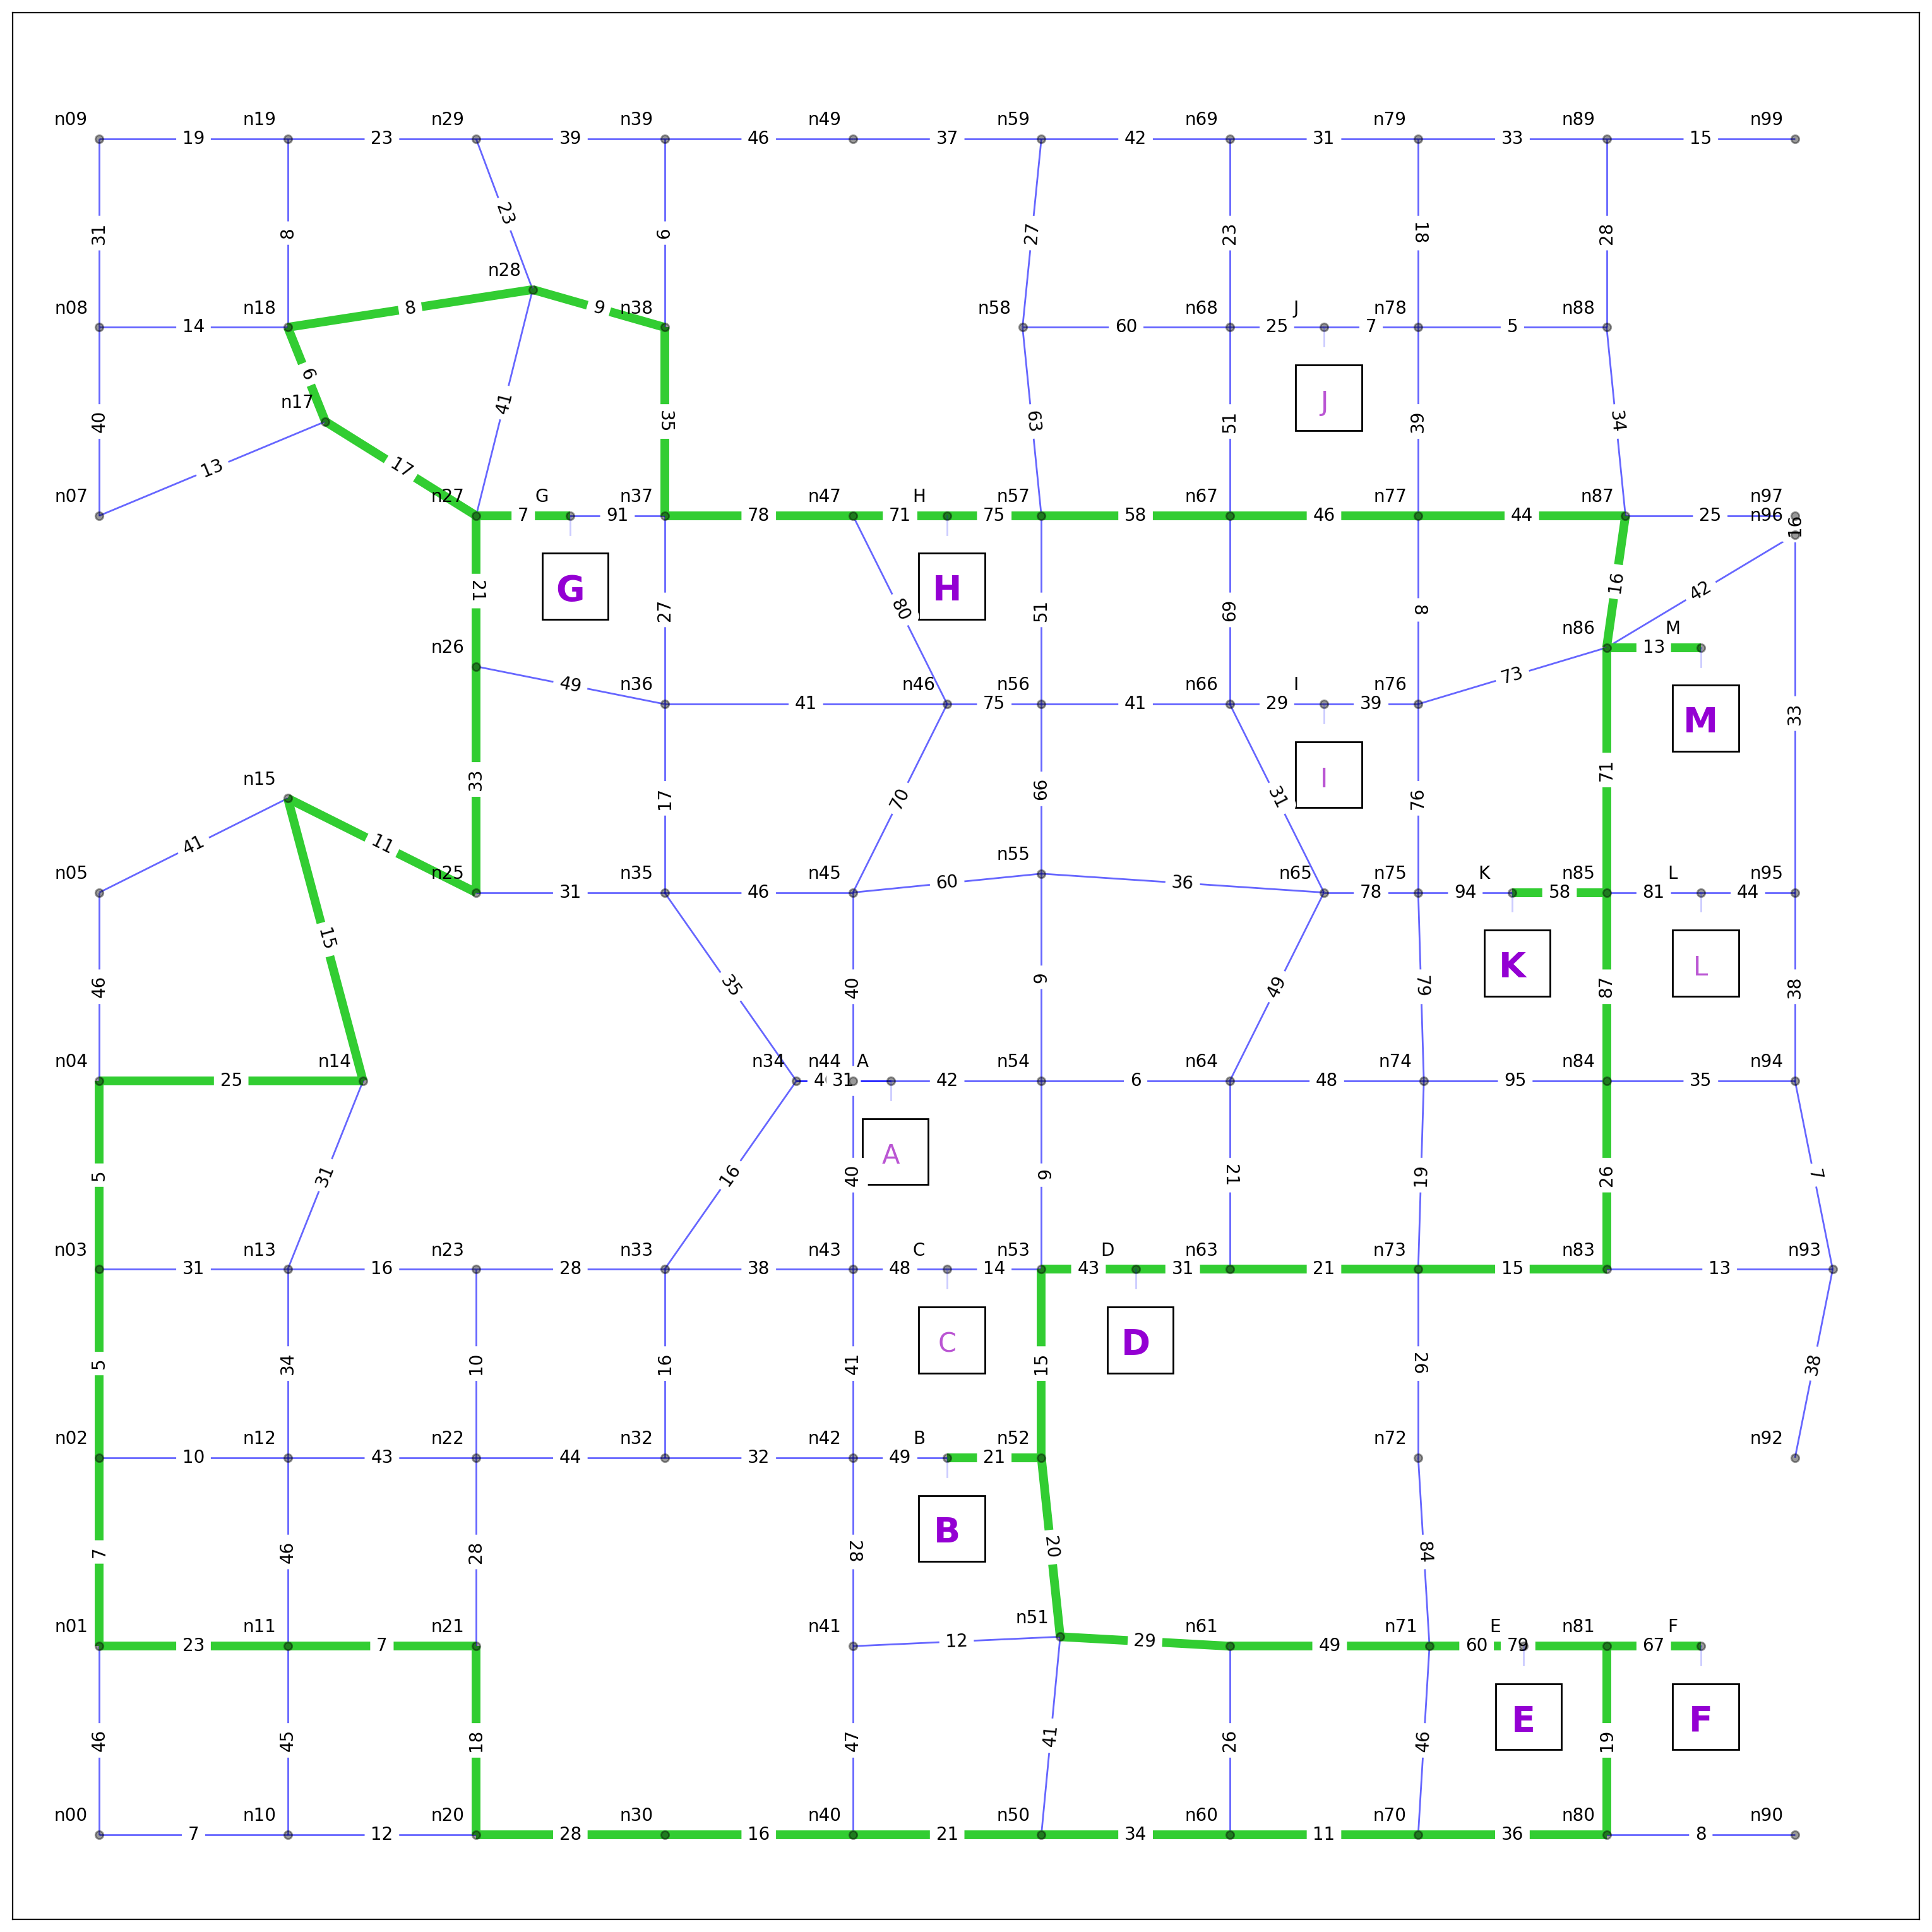

In [11]:
TSP_tours('traffic',G,2,'heavy')

## Add both conditions to our problem

In [24]:
def TSP_tours_both(graph,r,rain_degree,traffic_degree):
    '''
    r: radius of the area be affected
    degree: degree of conditions
    '''
    Buildings = [b['id'] for b in city.building_nodes if b['num_bikes']>=30]
    print('Buildings we choose:',Buildings)

    rain_center = iimp6010.random_select(Buildings,1)[0]
    print('We choose the building %s as the rain center'%rain_center)
    traffic_center = iimp6010.random_select(Buildings,1)[0]
    print('We choose the building %s as the traffic center'%traffic_center)

    
    # Update the graph with new weights for a certain area.
    G_new,rain_edges = rain(graph,rain_center,r*100,rain_degree,False)
    G_new,traffic_edges = traffic(G_new,traffic_center,r,traffic_degree,False)
    iimp6010.visualize_both_condition(city,rain_edges,traffic_edges,rain_degree,traffic_degree)
    path = best_tours(Buildings)
    visualization_of_tours(path)
    return

Buildings we choose: ['B', 'D', 'E', 'F', 'G', 'H', 'K', 'M']
We choose the building F as the rain center
We choose the building K as the traffic center
Previous ego-graph:


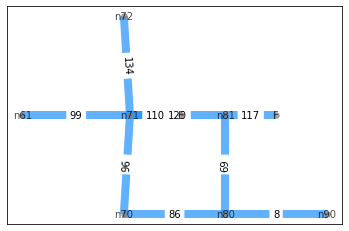

Ego-graph with weights updated:
Previous ego-graph:


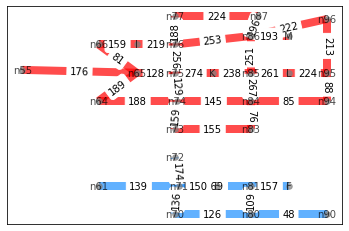

Ego-graph with weights updated:


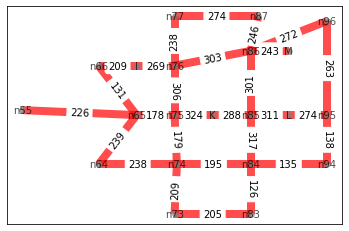

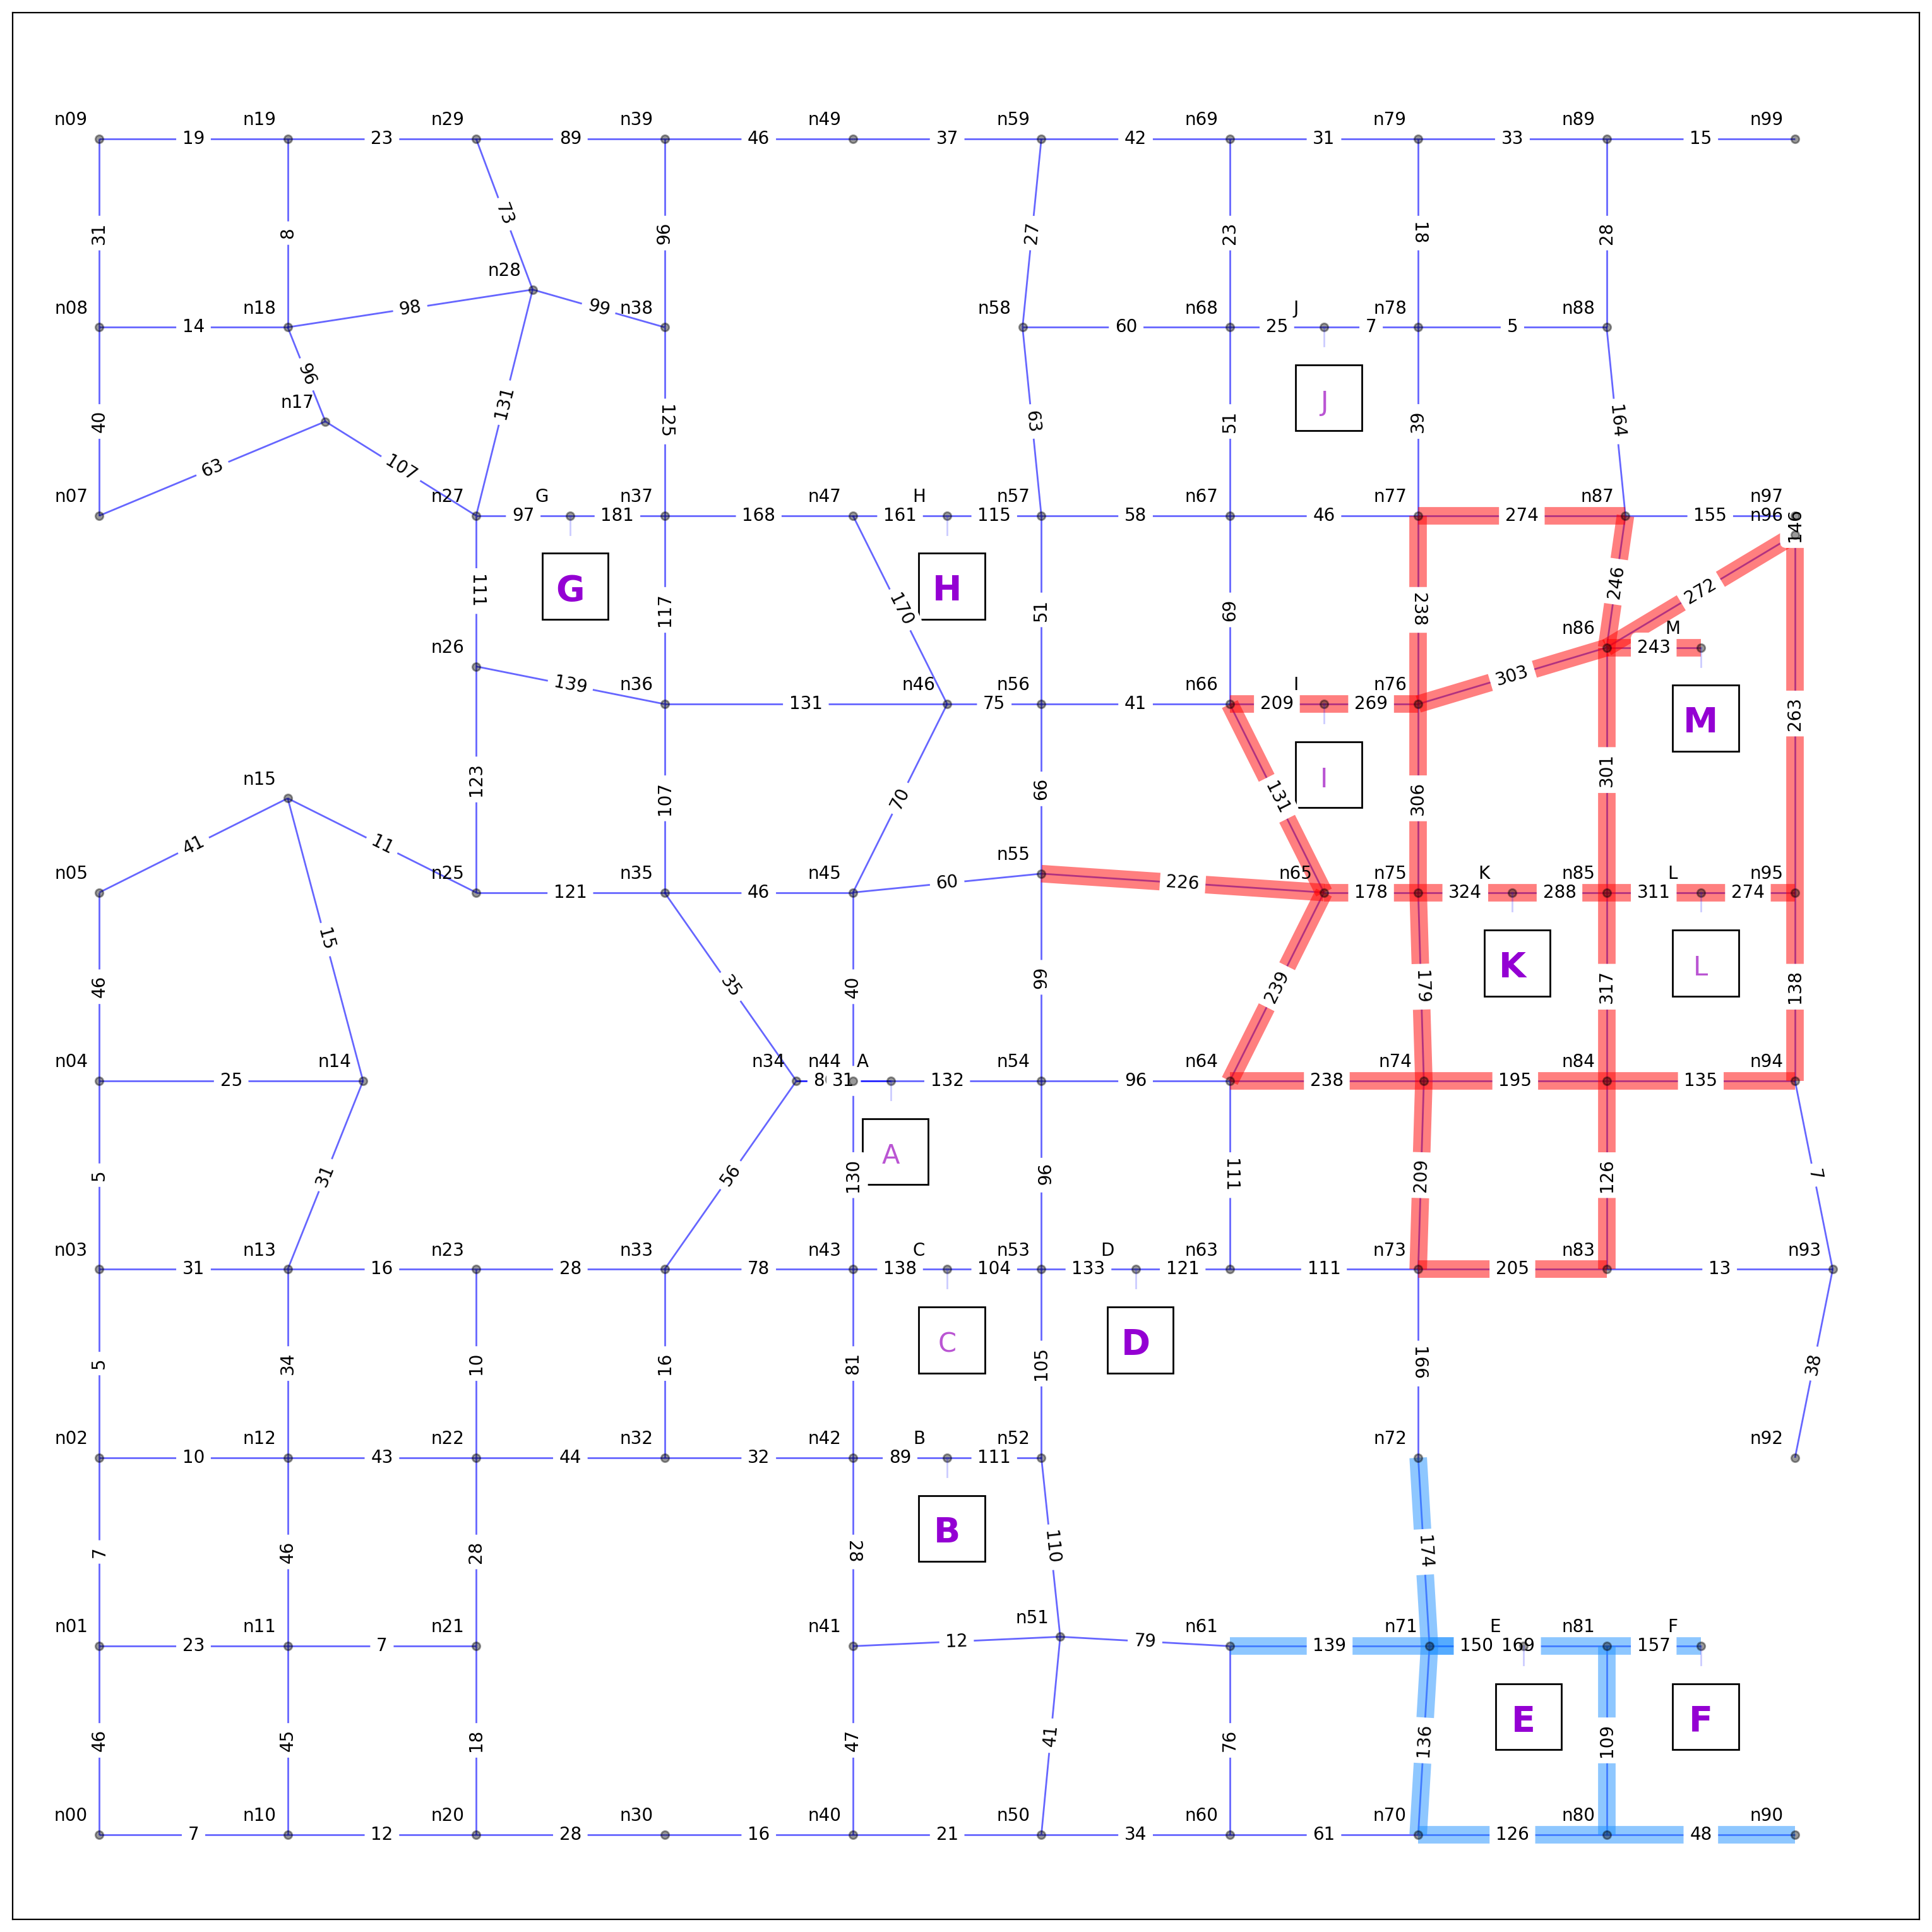

The best fitness is 5521.00
Shortest tours: ['K', 'D', 'B', 'E', 'F', 'G', 'H', 'M']


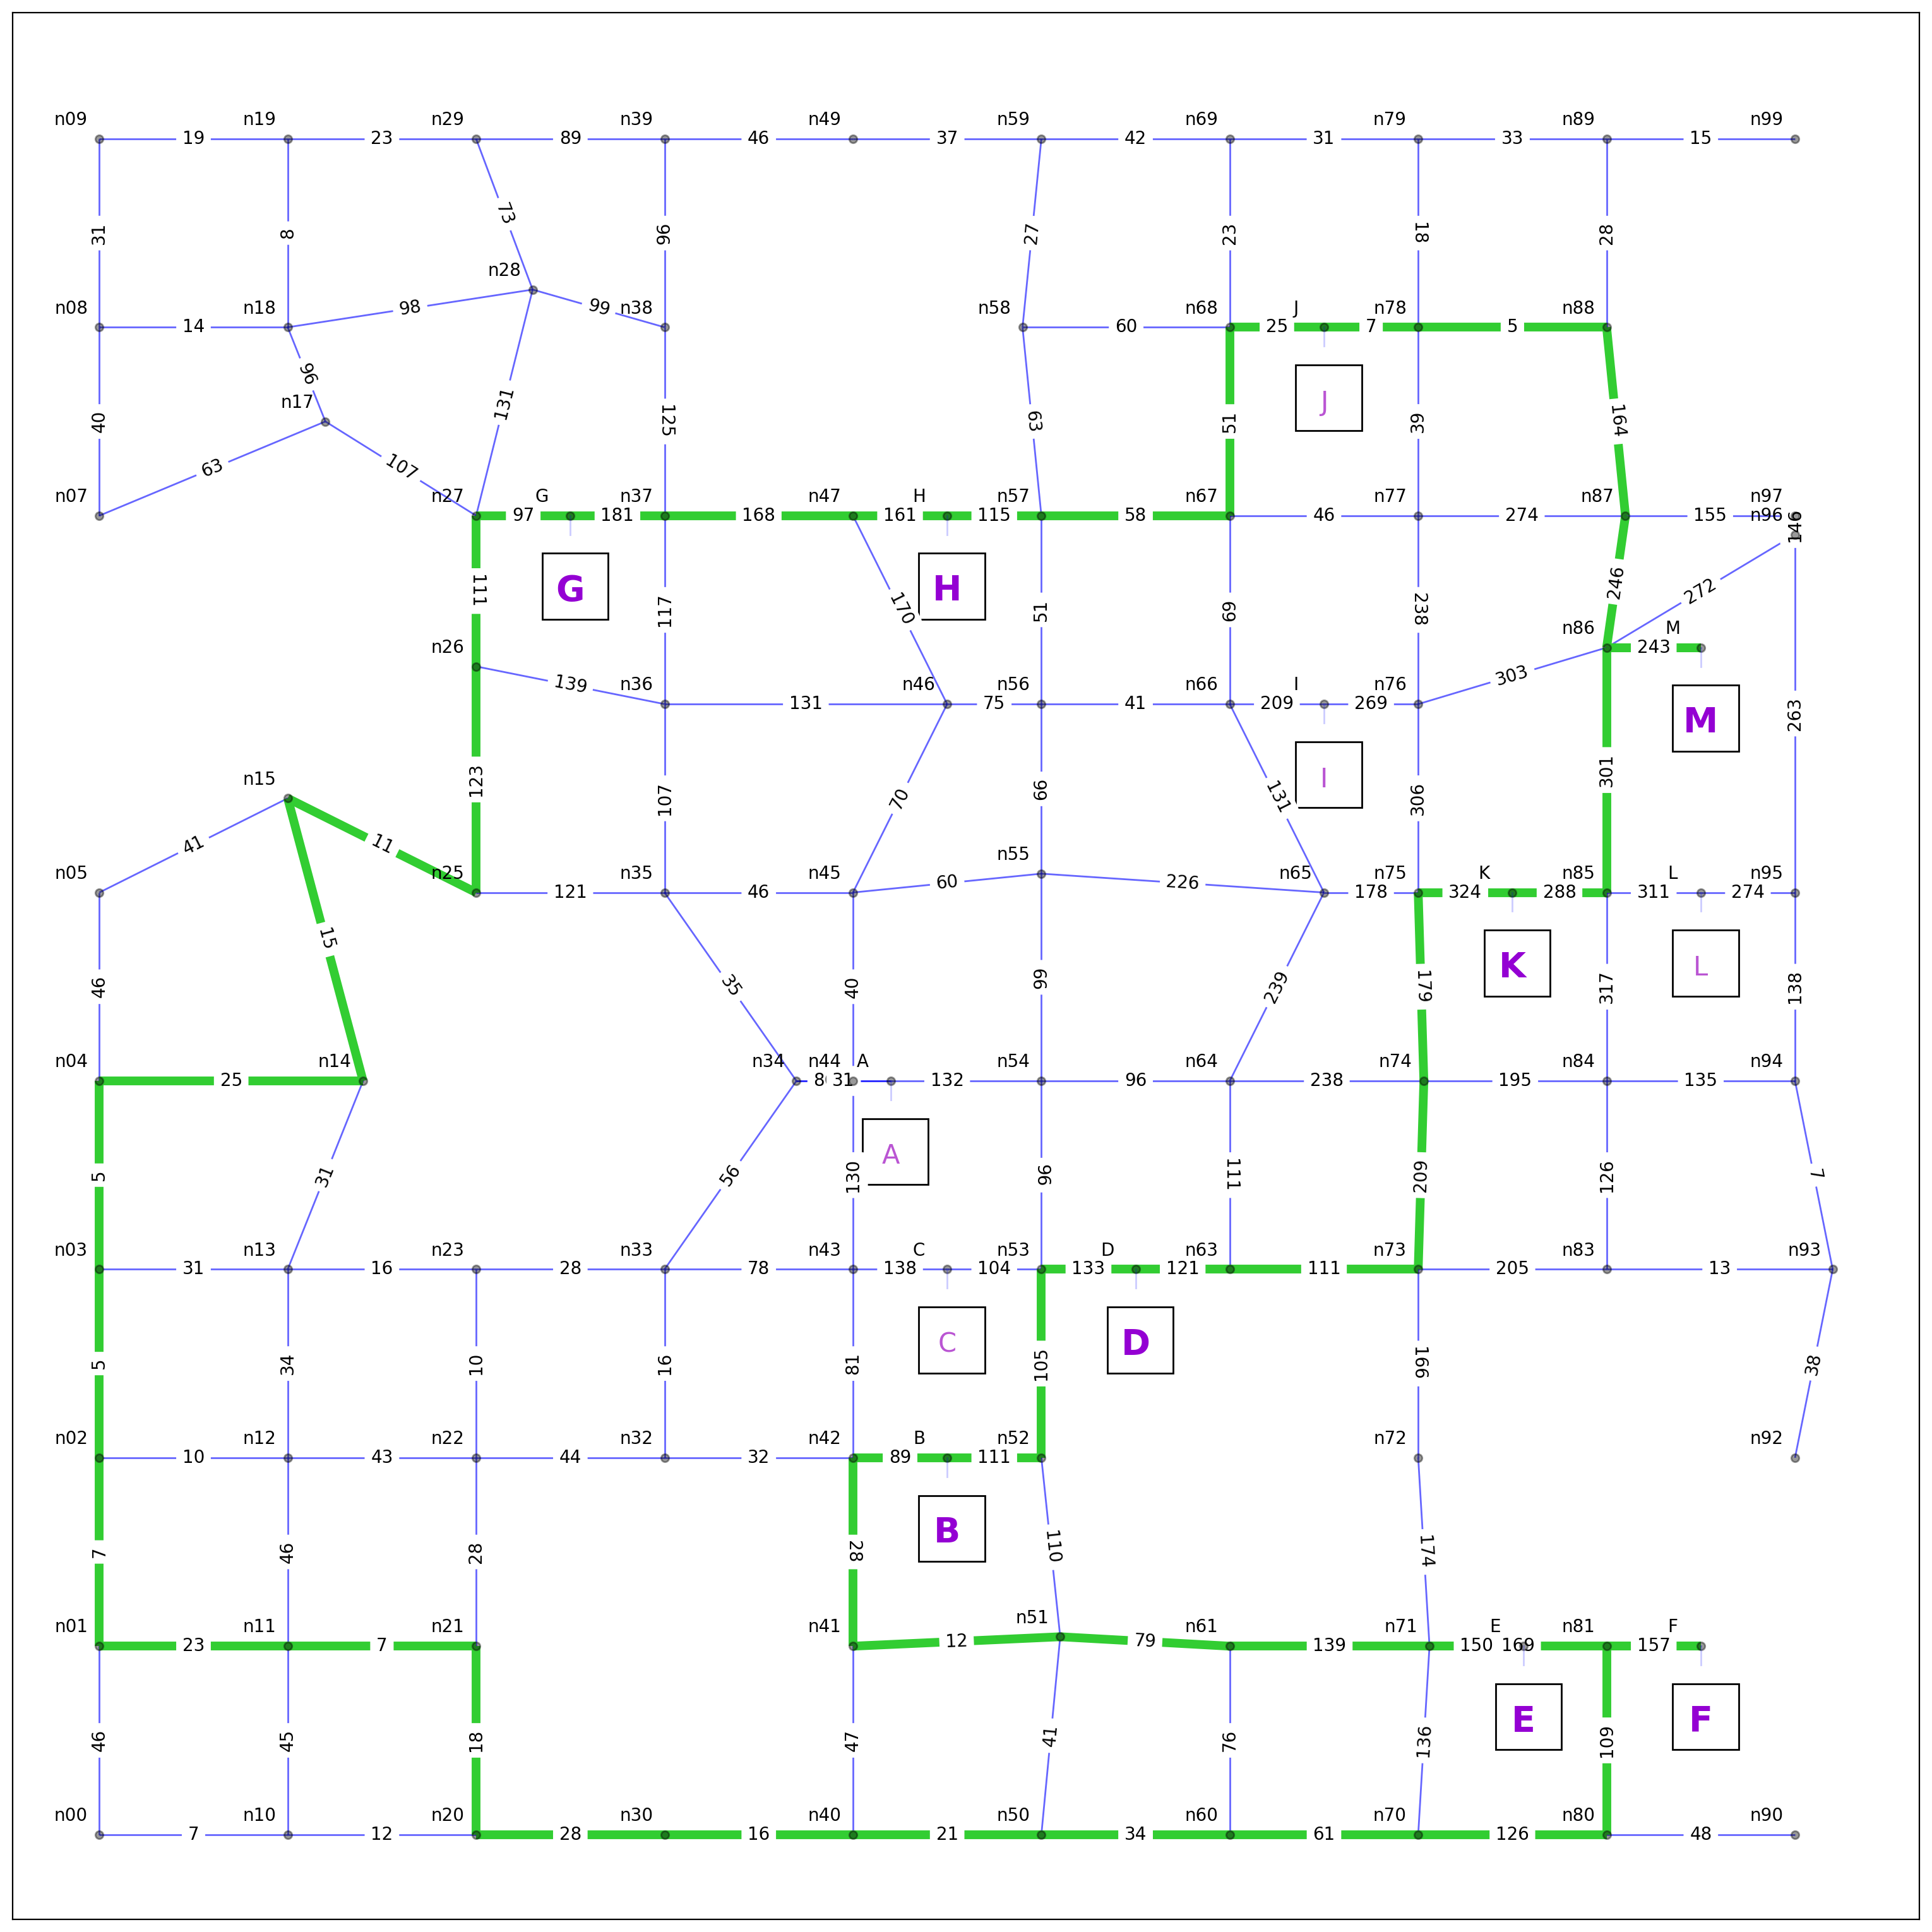

In [26]:
TSP_tours_both(G,3,'heavy','heavy')